# Random Forest Model Creation to Identify and Classify UCDs

In [1]:
#imports

# std lib
from getpass import getpass

# standard
import numpy as np
import pylab as plt
import matplotlib
%matplotlib inline
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.lines as mlines
import matplotlib.style
import matplotlib as mpl
import pandas as pd
from numpy.polynomial import polynomial as P

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc

# machine learning
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report, \
PrecisionRecallDisplay, RocCurveDisplay, f1_score, recall_score, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold,RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.calibration import calibration_curve

# others
from dl.helpers.utils import convert
import os
import warnings
from pathlib import Path
from typing import Iterable, List, Optional, Union
import seaborn as sns

In [2]:
# Login for Astro Data Lab

token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))

Enter user name: (+ENTER)  malinadesai
Enter password: (+ENTER)  ·········


In [3]:
# initializing a dataframe to keep track of scores

model_performances = pd.DataFrame()

In [91]:
# initialize new dataframe for brightness bias

brightness_bias = pd.DataFrame()

In [71]:
# functions
    
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_norm_cm(y_test, y_pred, row_labels = ['Contaminants', 'UCDs'], col_labels = ['Contaminants', 'UCDs'], 
                 cbar_kw=None, cbarlabel=None, **kwargs):
    """
    Create a heatmap from sklearn confusion matrix and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """
    data = confusion_matrix(y_test, y_pred, normalize = 'true')

    if cbar_kw is None:
        cbar_kw = {}
        
    fig, ax = plt.subplots(figsize=(5.5, 5.5))
    
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)
   
    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the x tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize = 15)
    
    # Rotate the y tick labels and set their alignment.
    plt.setp(ax.get_yticklabels(), rotation=90, ha="center", rotation_mode="anchor", fontsize = 15)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.tick_params(which="minor", pad = 1, top = False, bottom=False, left=False,)
    
    ax.set_ylabel("True", fontsize=20)
    ax.set_xlabel("Predicted", fontsize=20)
    texts = annotate_heatmap(im, valfmt="{x:.2%}", size=15)
    fig.tight_layout()

    
def plot_feature_importance(model: RandomForestClassifier, feature_names: Iterable[str], 
                            n: int = 10, file_name: Optional[str] = None, error_bars: bool = False,
                           ) -> pd.DataFrame:
    """Plot the feature importance of a fit RF model.
    Parameters
    ----------
    model : RandomForestClassifier
        Model trained on templates.
    feature_names : Iterable[str]
        Names of the features for the plot.
    n : int
        Top n most important features to plot.
    file_name : str, optional
        File name for saving the feature importance plot.
    error_bars : bool
        Whether to plot error bars in the feature importance plot.
    Returns
    -------
    pd.DataFrame
        Feature importance DataFrame.
    """
    feature_importance = model.feature_importances_
    std = np.std(
        [tree.feature_importances_ for tree in model.estimators_], axis=0
    )

    data = {
        "feature_names": feature_names,
        "feature_importance": feature_importance,
        "std": std,
    }
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    fi_df = fi_df.iloc[:n]

    plt.figure(figsize=(8, 6))

    if error_bars:
        plt.barh(range(len(fi_df))[::-1], fi_df["feature_importance"], color = 'lightsteelblue', xerr=fi_df["std"],
            edgecolor="black",
        )
    else:
        plt.barh(
            range(len(fi_df))[::-1],
            fi_df["feature_importance"],
            color= 'lightsteelblue',
            edgecolor="black",
        )

    plt.yticks(ticks=range(len(fi_df)), labels=fi_df["feature_names"][::-1])
    # plt.title(f"{model.__class__.__name__} Feature Importance")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Names")

    if file_name:
        plt.savefig(file_name)

    plt.show()

def store_model_performace(model, modelname, x_train, x_test, y_train, y_test):
    '''
    model : RandomForestClassifier
    modelname : string identifying experiment name
    '''
    
    # do the prediction
    y_pred = model.predict(x_test)
    
    # get the scores and confusion matrix
    precision_no = precision_score(y_test, y_pred)
    accuracy_no = accuracy_score(y_test, y_pred)
    f1_no = f1_score(y_test, y_pred)
    recall_no = recall_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # store those numbers in a dataframe
    model_performances[modelname] = [precision_no, accuracy_no, f1_no, recall_no, tn, fp, fn, tp]
    
    # print relevant information
    print("The raw features produce a model with precision ~{:.4f} !".format(precision_no))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
# adding noise function

def addNoise(photometry, unc, scale=1.0):
    """
    Resamples data to add noise, scaled according to input scale factor (scale > 1 => increased noise)
    Parameters
    ----------
    photometry : list or numpy array of floats
                    An array specifying flux density in f_lambda units
    unc : list or numpy array of floats
                    An array specifying uncertainty in the same units as flux
    scale : float, default = 1.
                    Scale factor to scale uncertainty array; scale > 1 reduces signal-to-noise
    Returns
    -------
    list or numpy array of floats
            flux with noise added
    list or numpy array of floats
            scaled uncertainty
    Examples
    --------
    >>> flux = np.random.normal(5, 0.2, 100)
    >>> unc = flux * 0.01
    >>> nflux, nunc = addNoise(flux, unc, scale=5.)
    """
    sunc = unc * scale
    if scale > 1.0:
        nunc = sunc
    else:
        nunc = unc
    nphot = np.random.normal(photometry, sunc)  # random number
    return nphot, nunc


In [5]:
# open ucd sample

all_ucds = pd.read_csv('corrected_UltracoolSheet.csv')

# open contaminant sample

all_contaminants = pd.read_csv('contaminant_sample.csv')

In [6]:
# take the necessary subset of columns

ucd_sample = all_ucds[['DES_r', 'DES_i', 'DES_z', 'DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2', \
                       'ucs_pmra', 'ucs_pmdec']].copy()

# rename columns

ucd_sample = ucd_sample.rename(columns = {'ucs_pmra' : 'pmra', 'ucs_pmdec' : 'pmdec'})
ucd_sample.columns

Index(['DES_r', 'DES_i', 'DES_z', 'DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1',
       'CAT_W2', 'pmra', 'pmdec'],
      dtype='object')

In [7]:
# converting proper motion units

ucd_sample['pmra'] = ucd_sample['pmra'].apply(lambda x: x*0.001)
ucd_sample['pmdec'] = ucd_sample['pmdec'].apply(lambda x: x*0.001)

In [8]:
# take necessary subset of columns

contaminant_sample = all_contaminants[['wavg_mag_psf_r', 'wavg_mag_psf_i', 'wavg_mag_psf_z', 'wavg_mag_psf_y', \
                                       'japermag3', 'ksapermag3', 'w1mpro', 'w2mpro', 'pmra', 'pmdec']].copy()

# rename columns

contaminant_sample = contaminant_sample.rename(columns = {'wavg_mag_psf_r' : 'DES_r', 'wavg_mag_psf_i' : 'DES_i', \
                                                          'wavg_mag_psf_z' : 'DES_z', 'wavg_mag_psf_y' : 'DES_y', \
                                                          'japermag3' : 'VISTA_J', 'ksapermag3' : 'VISTA_Ks', \
                                                          'w1mpro' : 'CAT_W1', 'w2mpro' : 'CAT_W2'})
contaminant_sample.columns

Index(['DES_r', 'DES_i', 'DES_z', 'DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1',
       'CAT_W2', 'pmra', 'pmdec'],
      dtype='object')

In [9]:
# add binary classification: 

ucd_sample['label'] = 1
contaminant_sample['label'] = 0

# combine the two samples
full_sample = pd.concat([ucd_sample, contaminant_sample], axis = 0)
full_sample = full_sample.reset_index(drop = True)
full_sample

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,pmra,pmdec,label
0,NaN,NaN,NaN,NaN,NaN,NaN,16.878279,16.643610,-0.09000,-0.00800,1
1,NaN,NaN,18.215610,17.277765,14.956989,14.847686,NaN,NaN,-0.01910,0.12670,1
2,NaN,19.869041,18.276015,17.717456,15.432549,13.788503,12.974630,12.572687,0.14300,-0.17470,1
3,NaN,19.646879,18.017447,17.480256,15.614212,14.742863,14.353915,14.025337,0.33990,-0.30500,1
4,NaN,21.550391,19.752805,19.220955,17.072384,15.721730,14.829317,14.604430,0.02200,-0.04600,1
...,...,...,...,...,...,...,...,...,...,...,...
3734,17.659561,17.529726,17.482481,17.494793,16.580885,16.203932,15.929000,15.767000,-0.01860,-0.03915,0
3735,23.445010,20.599306,19.107980,18.691925,17.093600,16.273691,14.940000,14.906000,0.07081,-0.00134,0
3736,19.691936,18.155030,17.454308,17.263304,15.933051,15.025026,14.940000,14.906000,0.07081,-0.00134,0
3737,23.716251,21.508831,19.902794,19.386797,17.169792,15.884735,15.413000,15.143000,0.11342,-0.07621,0


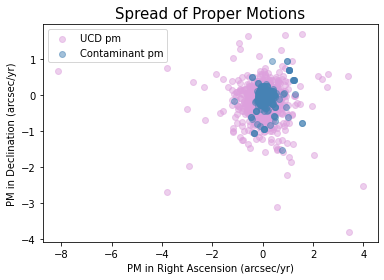

In [10]:
# spread of pmra and pmdec

plt.scatter(ucd_sample['pmra'], ucd_sample['pmdec'], alpha = 0.5, color = 'plum', label = 'UCD pm')
plt.scatter(contaminant_sample['pmra'], contaminant_sample['pmdec'], alpha = 0.5, color = 'steelblue', label = 'Contaminant pm')
plt.legend()
plt.title('Spread of Proper Motions', fontsize = 15)
plt.xlabel('PM in Right Ascension (arcsec/yr)')
plt.ylabel('PM in Declination (arcsec/yr)')
plt.savefig('pmspread.png')

# Random Forest Models

## Random Forest Model 1

This model uses the available 8 photometric bands from 3 deep sky surveys: r, i, z, Y from DES; J and Ks from VHS; and W1 and W2 from CatWISE2020. This model also uses pmra and pmdec values from the UltracoolSheet for UCDs and from CatWISE2020 for contaminants for a total of 10 features. 

In [11]:
# select columns for model 1 and clean

model1_sample = full_sample[['DES_r', 'DES_i', 'DES_z', 'DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2', \
                             'pmra', 'pmdec', 'label']].copy()
model1_sample = model1_sample.dropna()
model1_sample = model1_sample.reset_index(drop = True)
model1_sample

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,pmra,pmdec,label
0,18.902018,16.362285,15.006034,14.597053,12.971069,12.020320,11.715541,11.548368,0.28670,-0.14543,1
1,18.583630,15.934942,14.451741,13.978654,12.306149,11.440610,11.066067,10.776617,0.75823,0.08520,1
2,19.325241,16.660843,15.217814,14.760754,13.176828,12.248350,11.901234,11.654826,0.71080,-0.12481,1
3,22.221409,19.805663,18.261373,17.708156,15.570878,14.081758,13.482135,13.210293,-0.03300,0.01040,1
4,16.957182,14.697692,13.598549,13.301750,11.867781,11.129087,10.894397,10.690052,-0.06100,-0.32135,1
...,...,...,...,...,...,...,...,...,...,...,...
1579,17.659561,17.529726,17.482481,17.494793,16.580885,16.203932,15.929000,15.767000,-0.01860,-0.03915,0
1580,23.445010,20.599306,19.107980,18.691925,17.093600,16.273691,14.940000,14.906000,0.07081,-0.00134,0
1581,19.691936,18.155030,17.454308,17.263304,15.933051,15.025026,14.940000,14.906000,0.07081,-0.00134,0
1582,23.716251,21.508831,19.902794,19.386797,17.169792,15.884735,15.413000,15.143000,0.11342,-0.07621,0


In [12]:
# creating the random forest model

RSEED = 42  

X1, y1 = model1_sample.drop(columns='label'), model1_sample['label']

x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size = 0.75, random_state=RSEED, shuffle=True)

RF_model1 = RandomForestClassifier(n_estimators = 50, class_weight = None)
RF_model1.fit(x_train1, y_train1)

RandomForestClassifier(n_estimators=50)

In [14]:
# do the prediction

y_pred1 = RF_model1.predict(x_test1)

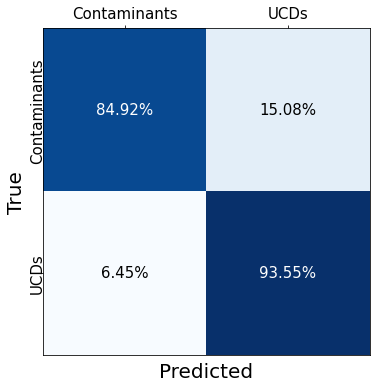

In [17]:
# plot normalized confusion matrix

plot_norm_cm(y_test1, y_pred1, cmap = 'Blues')

In [21]:
# finding and storing the model performance

store_model_performace(RF_model1, 'model1', x_train1, x_test1, y_train1, y_test1)
model_performances

The raw features produce a model with precision ~0.8826 !
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       179
           1       0.88      0.94      0.91       217

    accuracy                           0.90       396
   macro avg       0.90      0.89      0.89       396
weighted avg       0.90      0.90      0.90       396

[[152  27]
 [ 14 203]]


,model1
0,0.882609
1,0.896465
2,0.908277
3,0.935484
4,152.000000
5,27.000000
6,14.000000
7,203.000000


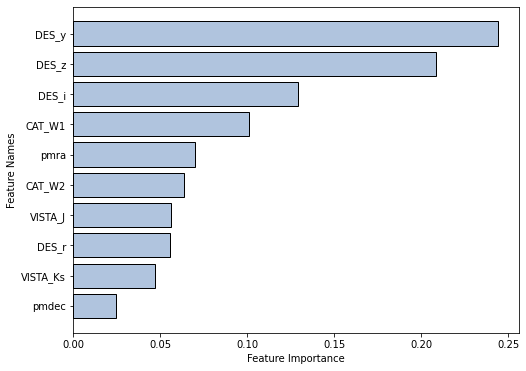

In [25]:
# plot feature importances

plot_feature_importance(RF_model1, model1_sample.drop(columns='label').columns, 10, 'model1features')

## Random Forest Model 2

In [26]:
# drop proper motion columns

model2_sample = model1_sample.copy()
model2_sample = model2_sample.drop(columns = ['pmra', 'pmdec'])
model2_sample

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,18.902018,16.362285,15.006034,14.597053,12.971069,12.020320,11.715541,11.548368,1
1,18.583630,15.934942,14.451741,13.978654,12.306149,11.440610,11.066067,10.776617,1
2,19.325241,16.660843,15.217814,14.760754,13.176828,12.248350,11.901234,11.654826,1
3,22.221409,19.805663,18.261373,17.708156,15.570878,14.081758,13.482135,13.210293,1
4,16.957182,14.697692,13.598549,13.301750,11.867781,11.129087,10.894397,10.690052,1
...,...,...,...,...,...,...,...,...,...
1579,17.659561,17.529726,17.482481,17.494793,16.580885,16.203932,15.929000,15.767000,0
1580,23.445010,20.599306,19.107980,18.691925,17.093600,16.273691,14.940000,14.906000,0
1581,19.691936,18.155030,17.454308,17.263304,15.933051,15.025026,14.940000,14.906000,0
1582,23.716251,21.508831,19.902794,19.386797,17.169792,15.884735,15.413000,15.143000,0


In [27]:
# creating the random forest model

RSEED = 42  

X2, y2 = model2_sample.drop(columns='label'), model2_sample['label']

x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size = 0.75, random_state=RSEED, shuffle=True)

RF_model2 = RandomForestClassifier(n_estimators = 50, class_weight = None)
RF_model2.fit(x_train2, y_train2)

RandomForestClassifier(n_estimators=50)

In [28]:
# do the prediction

y_pred2 = RF_model2.predict(x_test2)

In [29]:
# finding and storing the model performance

store_model_performace(RF_model2, 'model2', x_train2, x_test2, y_train2, y_test2)
model_performances

The raw features produce a model with precision ~0.8861 !
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       179
           1       0.89      0.97      0.93       217

    accuracy                           0.91       396
   macro avg       0.92      0.91      0.91       396
weighted avg       0.92      0.91      0.91       396

[[152  27]
 [  7 210]]


,model1,model2
0,0.882609,0.886076
1,0.896465,0.914141
2,0.908277,0.925110
3,0.935484,0.967742
4,152.000000,152.000000
5,27.000000,27.000000
6,14.000000,7.000000
7,203.000000,210.000000


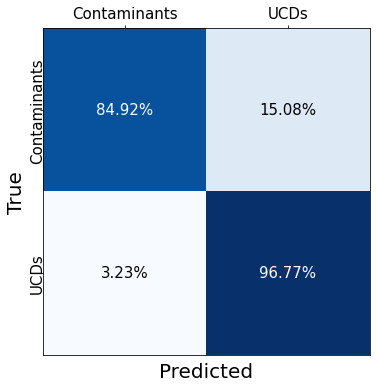

In [31]:
plot_norm_cm(y_test2, y_pred2, cmap = 'Blues')

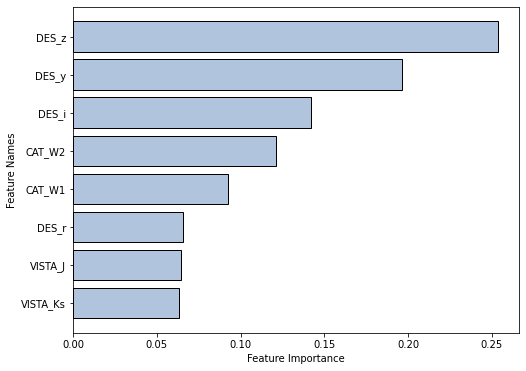

In [34]:
# plot feature importances

plot_feature_importance(RF_model2, model2_sample.drop(columns='label').columns, 8, 'model2features')

## Random Forest Model 3

In [35]:
# create dataframe with all of the color combinations:

color_sample = model1_sample.copy()

for i in range(len(full_sample.columns) - 4):
    for j in range(0, 8): 
        if i != j and i < j:
            color_sample[color_sample.columns[i] + '_' + color_sample.columns[j]] = color_sample.iloc[:, i] - color_sample.iloc[:, j]

color_sample

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,pmra,pmdec,...,DES_y_VISTA_J,DES_y_VISTA_Ks,DES_y_CAT_W1,DES_y_CAT_W2,VISTA_J_VISTA_Ks,VISTA_J_CAT_W1,VISTA_J_CAT_W2,VISTA_Ks_CAT_W1,VISTA_Ks_CAT_W2,CAT_W1_CAT_W2
0,18.902018,16.362285,15.006034,14.597053,12.971069,12.020320,11.715541,11.548368,0.28670,-0.14543,...,1.625984,2.576733,2.881512,3.048685,0.950749,1.255528,1.422701,0.304778,0.471952,0.167173
1,18.583630,15.934942,14.451741,13.978654,12.306149,11.440610,11.066067,10.776617,0.75823,0.08520,...,1.672505,2.538044,2.912587,3.202037,0.865539,1.240082,1.529532,0.374543,0.663992,0.289449
2,19.325241,16.660843,15.217814,14.760754,13.176828,12.248350,11.901234,11.654826,0.71080,-0.12481,...,1.583925,2.512404,2.859520,3.105928,0.928478,1.275595,1.522003,0.347116,0.593524,0.246408
3,22.221409,19.805663,18.261373,17.708156,15.570878,14.081758,13.482135,13.210293,-0.03300,0.01040,...,2.137278,3.626398,4.226021,4.497862,1.489120,2.088743,2.360584,0.599623,0.871465,0.271842
4,16.957182,14.697692,13.598549,13.301750,11.867781,11.129087,10.894397,10.690052,-0.06100,-0.32135,...,1.433970,2.172663,2.407353,2.611698,0.738693,0.973384,1.177729,0.234690,0.439036,0.204345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,17.659561,17.529726,17.482481,17.494793,16.580885,16.203932,15.929000,15.767000,-0.01860,-0.03915,...,0.913908,1.290861,1.565793,1.727793,0.376953,0.651885,0.813885,0.274932,0.436932,0.162000
1580,23.445010,20.599306,19.107980,18.691925,17.093600,16.273691,14.940000,14.906000,0.07081,-0.00134,...,1.598325,2.418234,3.751925,3.785925,0.819909,2.153600,2.187600,1.333691,1.367691,0.034000
1581,19.691936,18.155030,17.454308,17.263304,15.933051,15.025026,14.940000,14.906000,0.07081,-0.00134,...,1.330253,2.238278,2.323304,2.357304,0.908025,0.993051,1.027051,0.085026,0.119026,0.034000
1582,23.716251,21.508831,19.902794,19.386797,17.169792,15.884735,15.413000,15.143000,0.11342,-0.07621,...,2.217005,3.502062,3.973797,4.243797,1.285057,1.756792,2.026792,0.471735,0.741735,0.270000


In [36]:
# creating a dataframe with colors as the only feature, retaining the labels

color_sample_model3 = color_sample.copy()
color_sample_model3 = color_sample_model3.iloc[:, -29:]
color_sample_model3

,label,DES_r_DES_i,DES_r_DES_z,DES_r_DES_y,DES_r_VISTA_J,DES_r_VISTA_Ks,DES_r_CAT_W1,DES_r_CAT_W2,DES_i_DES_z,DES_i_DES_y,...,DES_y_VISTA_J,DES_y_VISTA_Ks,DES_y_CAT_W1,DES_y_CAT_W2,VISTA_J_VISTA_Ks,VISTA_J_CAT_W1,VISTA_J_CAT_W2,VISTA_Ks_CAT_W1,VISTA_Ks_CAT_W2,CAT_W1_CAT_W2
0,1,2.539733,3.895983,4.304965,5.930949,6.881698,7.186477,7.353650,1.356251,1.765233,...,1.625984,2.576733,2.881512,3.048685,0.950749,1.255528,1.422701,0.304778,0.471952,0.167173
1,1,2.648687,4.131889,4.604975,6.277480,7.143020,7.517563,7.807012,1.483202,1.956288,...,1.672505,2.538044,2.912587,3.202037,0.865539,1.240082,1.529532,0.374543,0.663992,0.289449
2,1,2.664398,4.107427,4.564488,6.148413,7.076891,7.424008,7.670416,1.443029,1.900090,...,1.583925,2.512404,2.859520,3.105928,0.928478,1.275595,1.522003,0.347116,0.593524,0.246408
3,1,2.415746,3.960036,4.513253,6.650531,8.139651,8.739274,9.011116,1.544290,2.097507,...,2.137278,3.626398,4.226021,4.497862,1.489120,2.088743,2.360584,0.599623,0.871465,0.271842
4,1,2.259490,3.358633,3.655432,5.089402,5.828095,6.062785,6.267130,1.099143,1.395942,...,1.433970,2.172663,2.407353,2.611698,0.738693,0.973384,1.177729,0.234690,0.439036,0.204345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,0,0.129835,0.177080,0.164768,1.078676,1.455629,1.730561,1.892561,0.047245,0.034933,...,0.913908,1.290861,1.565793,1.727793,0.376953,0.651885,0.813885,0.274932,0.436932,0.162000
1580,0,2.845704,4.337030,4.753085,6.351410,7.171319,8.505010,8.539010,1.491326,1.907381,...,1.598325,2.418234,3.751925,3.785925,0.819909,2.153600,2.187600,1.333691,1.367691,0.034000
1581,0,1.536906,2.237628,2.428632,3.758885,4.666910,4.751936,4.785936,0.700722,0.891726,...,1.330253,2.238278,2.323304,2.357304,0.908025,0.993051,1.027051,0.085026,0.119026,0.034000
1582,0,2.207420,3.813457,4.329454,6.546459,7.831516,8.303251,8.573251,1.606037,2.122034,...,2.217005,3.502062,3.973797,4.243797,1.285057,1.756792,2.026792,0.471735,0.741735,0.270000


In [37]:
# random forest with only colors

RSEED = 42  

X3, y3 = color_sample_model3.drop(columns='label'), color_sample_model3['label']

x_train3, x_test3, y_train3, y_test3 = train_test_split(X3, y3, train_size = 0.75, random_state=RSEED, shuffle=True)

RF_model3 = RandomForestClassifier(n_estimators = 50, class_weight = None)
RF_model3.fit(x_train3, y_train3)

RandomForestClassifier(n_estimators=50)

In [38]:
# do the prediction

y_pred3 = RF_model3.predict(x_test3)

In [39]:
# finding and storing the model performance

store_model_performace(RF_model3, 'model3', x_train3, x_test3, y_train3, y_test3)
model_performances

The raw features produce a model with precision ~0.9279 !
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       179
           1       0.93      0.95      0.94       217

    accuracy                           0.93       396
   macro avg       0.93      0.93      0.93       396
weighted avg       0.93      0.93      0.93       396

[[163  16]
 [ 11 206]]


,model1,model2,model3
0,0.882609,0.886076,0.927928
1,0.896465,0.914141,0.931818
2,0.908277,0.925110,0.938497
3,0.935484,0.967742,0.949309
4,152.000000,152.000000,163.000000
5,27.000000,27.000000,16.000000
6,14.000000,7.000000,11.000000
7,203.000000,210.000000,206.000000


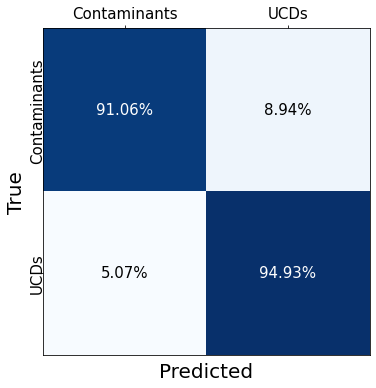

In [40]:
plot_norm_cm(y_test3, y_pred3, cmap = 'Blues')

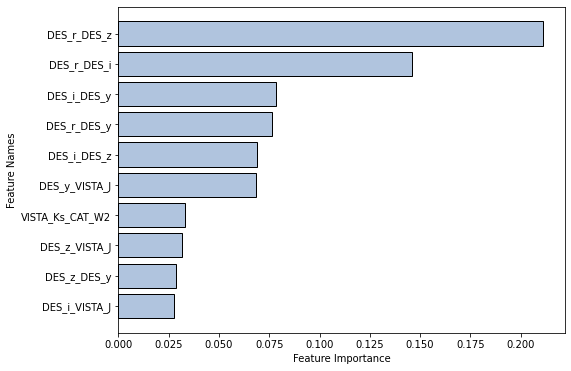

In [42]:
# plot feature importances

plot_feature_importance(RF_model3, color_sample_model3.drop(columns='label').columns, 10, 'model3features')

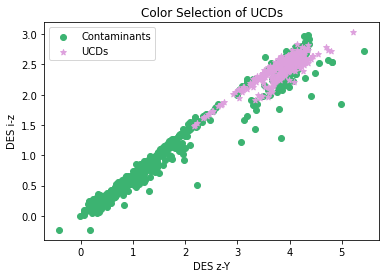

In [44]:
# plot best colors

plt.scatter(color_sample_model3.loc[color_sample_model3['label'] == 0].iloc[:,color_sample_model3.columns.get_loc('DES_r_DES_z')], 
            color_sample_model3.loc[color_sample_model3['label'] == 0].iloc[:,color_sample_model3.columns.get_loc('DES_r_DES_i')],
                        label = 'Contaminants',  color = 'mediumseagreen')
plt.scatter(color_sample_model3.loc[color_sample_model3['label'] == 1].iloc[:,color_sample_model3.columns.get_loc('DES_r_DES_z')], 
            color_sample_model3.loc[color_sample_model3['label'] == 1].iloc[:,color_sample_model3.columns.get_loc('DES_r_DES_i')],
                        label = 'UCDs', color = 'plum', marker = '*')
plt.title('Color Selection of UCDs')
plt.xlabel('DES z-Y')
plt.ylabel('DES i-z')
plt.legend()
plt.savefig('model3bestcolors.png')
plt.show()

## Random Forest Model 4

In [61]:
# creating a dataframe with colors as the only feature, retaining the labels

color_sample_model4 = color_sample.copy()
color_sample_model4 = color_sample_model4.iloc[:, -31:]
color_sample_model4

,pmra,pmdec,label,DES_r_DES_i,DES_r_DES_z,DES_r_DES_y,DES_r_VISTA_J,DES_r_VISTA_Ks,DES_r_CAT_W1,DES_r_CAT_W2,...,DES_y_VISTA_J,DES_y_VISTA_Ks,DES_y_CAT_W1,DES_y_CAT_W2,VISTA_J_VISTA_Ks,VISTA_J_CAT_W1,VISTA_J_CAT_W2,VISTA_Ks_CAT_W1,VISTA_Ks_CAT_W2,CAT_W1_CAT_W2
0,0.28670,-0.14543,1,2.539733,3.895983,4.304965,5.930949,6.881698,7.186477,7.353650,...,1.625984,2.576733,2.881512,3.048685,0.950749,1.255528,1.422701,0.304778,0.471952,0.167173
1,0.75823,0.08520,1,2.648687,4.131889,4.604975,6.277480,7.143020,7.517563,7.807012,...,1.672505,2.538044,2.912587,3.202037,0.865539,1.240082,1.529532,0.374543,0.663992,0.289449
2,0.71080,-0.12481,1,2.664398,4.107427,4.564488,6.148413,7.076891,7.424008,7.670416,...,1.583925,2.512404,2.859520,3.105928,0.928478,1.275595,1.522003,0.347116,0.593524,0.246408
3,-0.03300,0.01040,1,2.415746,3.960036,4.513253,6.650531,8.139651,8.739274,9.011116,...,2.137278,3.626398,4.226021,4.497862,1.489120,2.088743,2.360584,0.599623,0.871465,0.271842
4,-0.06100,-0.32135,1,2.259490,3.358633,3.655432,5.089402,5.828095,6.062785,6.267130,...,1.433970,2.172663,2.407353,2.611698,0.738693,0.973384,1.177729,0.234690,0.439036,0.204345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,-0.01860,-0.03915,0,0.129835,0.177080,0.164768,1.078676,1.455629,1.730561,1.892561,...,0.913908,1.290861,1.565793,1.727793,0.376953,0.651885,0.813885,0.274932,0.436932,0.162000
1580,0.07081,-0.00134,0,2.845704,4.337030,4.753085,6.351410,7.171319,8.505010,8.539010,...,1.598325,2.418234,3.751925,3.785925,0.819909,2.153600,2.187600,1.333691,1.367691,0.034000
1581,0.07081,-0.00134,0,1.536906,2.237628,2.428632,3.758885,4.666910,4.751936,4.785936,...,1.330253,2.238278,2.323304,2.357304,0.908025,0.993051,1.027051,0.085026,0.119026,0.034000
1582,0.11342,-0.07621,0,2.207420,3.813457,4.329454,6.546459,7.831516,8.303251,8.573251,...,2.217005,3.502062,3.973797,4.243797,1.285057,1.756792,2.026792,0.471735,0.741735,0.270000


In [62]:
# random forest with only colors

RSEED = 42  

X4, y4 = color_sample_model4.drop(columns='label'), color_sample_model4['label']

x_train4, x_test4, y_train4, y_test4 = train_test_split(X4, y4, train_size = 0.75, random_state=RSEED, shuffle=True)

RF_model4 = RandomForestClassifier(n_estimators = 50, class_weight = None)
RF_model4.fit(x_train4, y_train4)

RandomForestClassifier(n_estimators=50)

In [63]:
# do the prediction

y_pred4 = RF_model4.predict(x_test4)

In [64]:
# finding and storing the model performance

store_model_performace(RF_model4, 'model4', x_train4, x_test4, y_train4, y_test4)
model_performances

The raw features produce a model with precision ~0.9248 !
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       179
           1       0.92      0.96      0.94       217

    accuracy                           0.94       396
   macro avg       0.94      0.93      0.94       396
weighted avg       0.94      0.94      0.94       396

[[162  17]
 [  8 209]]


,model1,model2,model3,model4
0,0.882609,0.886076,0.927928,0.924779
1,0.896465,0.914141,0.931818,0.936869
2,0.908277,0.925110,0.938497,0.943567
3,0.935484,0.967742,0.949309,0.963134
4,152.000000,152.000000,163.000000,162.000000
5,27.000000,27.000000,16.000000,17.000000
6,14.000000,7.000000,11.000000,8.000000
7,203.000000,210.000000,206.000000,209.000000


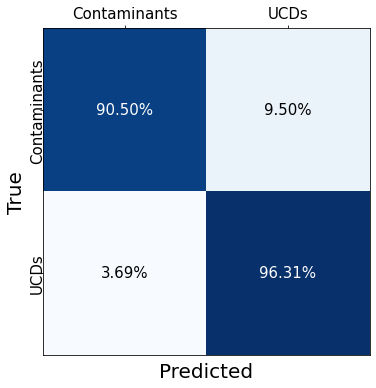

In [65]:
# normalized confusion matrix

plot_norm_cm(y_test4, y_pred4, cmap = 'Blues')

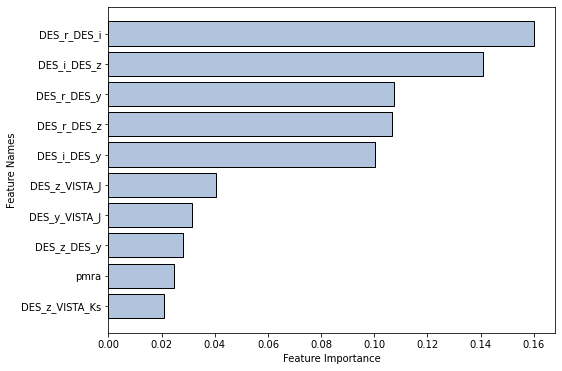

In [68]:
# plot feature importances

plot_feature_importance(RF_model4, color_sample_model4.drop(columns='label').columns, 10, 'model4features')

### Checking Brightness Bias

Text(0, 0.5, 'Counts')

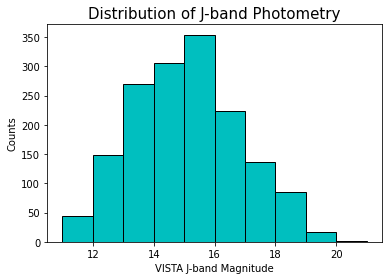

In [46]:
# variation in J-band photometry

bins = np.arange(11, 22, 1)
plt.hist(model1_sample['VISTA_J'], bins = bins, color='c', edgecolor='k')
plt.title('Distribution of J-band Photometry', fontsize = 15)
plt.xlabel('VISTA J-band Magnitude')
plt.ylabel('Counts')

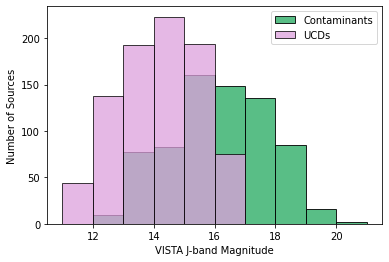

In [47]:
# highlighting UCDs in J-band photometry histogram

plt.hist(model1_sample.loc[model1_sample['label'] == 0]['VISTA_J'], bins = bins, color='mediumseagreen', \
         edgecolor='k', alpha = 0.85)
plt.hist(model1_sample.loc[model1_sample['label'] == 1]['VISTA_J'], bins= bins, color = 'plum', \
         edgecolor = 'k', alpha = 0.75)
#plt.title('Distribution of J-band Photometry', fontsize = 15)
plt.xlabel('VISTA J-band Magnitude')
plt.ylabel('Number of Sources')
plt.legend(('Contaminants', 'UCDs'))
plt.savefig('jbandhist.png')

In [51]:
# create dataframe for oversampling with noise

mc_sample = all_ucds[['DES_r', 'DES_i', 'DES_z', 'DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2', 'rerr_P1', \
                      'ierr_P1', 'zerr_P1', 'yerr_P1', 'Jerr_2MASS', 'Kserr_2MASS', 'W1err', 'W2err']].copy()
mc_sample = mc_sample.dropna()
mc_sample

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,rerr_P1,ierr_P1,zerr_P1,yerr_P1,Jerr_2MASS,Kserr_2MASS,W1err,W2err
5,18.902018,16.362285,15.006034,14.597053,12.971069,12.020320,11.715541,11.548368,0.01,0.00,0.00,0.00,0.024,0.025,0.024,0.023
9,18.583630,15.934942,14.451741,13.978654,12.306149,11.440610,11.066067,10.776617,0.01,0.00,0.00,0.01,0.022,0.023,0.023,0.020
12,19.325241,16.660843,15.217814,14.760754,13.176828,12.248350,11.901234,11.654826,0.01,0.00,0.00,0.01,0.025,0.030,0.023,0.022
15,22.221409,19.805663,18.261373,17.708156,15.570878,14.081758,13.482135,13.210293,0.10,0.01,0.01,0.01,0.065,0.052,0.026,0.028
20,16.957182,14.697692,13.598549,13.301750,11.867781,11.129087,10.894397,10.690052,0.01,0.01,0.00,0.00,0.023,0.023,0.022,0.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,18.729468,16.105663,14.631025,14.147254,12.375176,11.321788,10.961283,10.727592,0.00,0.00,0.00,0.00,0.026,0.026,0.023,0.021
2919,18.642824,16.123727,14.816750,14.418452,12.743090,11.790404,11.473063,11.182635,0.01,0.00,0.00,0.00,0.022,0.020,0.023,0.021
2921,19.172018,16.575303,15.101741,14.628654,12.936121,11.980530,11.625222,11.375880,0.02,0.00,0.00,0.00,0.026,0.027,0.022,0.021
2928,20.617988,18.099402,16.537447,16.000256,14.081518,13.089132,12.583139,12.312275,0.03,0.01,0.01,0.01,0.029,0.030,0.023,0.023


In [52]:
# add 0.01 noise to values that are 0: 

for i in range(8, 12):
    for j in range(len(mc_sample)):
        if mc_sample.iloc[j, i] < 0.01:
            mc_sample.iloc[j, i] = mc_sample.iloc[j, i] + 0.01

mc_sample

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,rerr_P1,ierr_P1,zerr_P1,yerr_P1,Jerr_2MASS,Kserr_2MASS,W1err,W2err
5,18.902018,16.362285,15.006034,14.597053,12.971069,12.020320,11.715541,11.548368,0.01,0.01,0.01,0.01,0.024,0.025,0.024,0.023
9,18.583630,15.934942,14.451741,13.978654,12.306149,11.440610,11.066067,10.776617,0.01,0.01,0.01,0.01,0.022,0.023,0.023,0.020
12,19.325241,16.660843,15.217814,14.760754,13.176828,12.248350,11.901234,11.654826,0.01,0.01,0.01,0.01,0.025,0.030,0.023,0.022
15,22.221409,19.805663,18.261373,17.708156,15.570878,14.081758,13.482135,13.210293,0.10,0.01,0.01,0.01,0.065,0.052,0.026,0.028
20,16.957182,14.697692,13.598549,13.301750,11.867781,11.129087,10.894397,10.690052,0.01,0.01,0.01,0.01,0.023,0.023,0.022,0.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,18.729468,16.105663,14.631025,14.147254,12.375176,11.321788,10.961283,10.727592,0.01,0.01,0.01,0.01,0.026,0.026,0.023,0.021
2919,18.642824,16.123727,14.816750,14.418452,12.743090,11.790404,11.473063,11.182635,0.01,0.01,0.01,0.01,0.022,0.020,0.023,0.021
2921,19.172018,16.575303,15.101741,14.628654,12.936121,11.980530,11.625222,11.375880,0.02,0.01,0.01,0.01,0.026,0.027,0.022,0.021
2928,20.617988,18.099402,16.537447,16.000256,14.081518,13.089132,12.583139,12.312275,0.03,0.01,0.01,0.01,0.029,0.030,0.023,0.023


In [55]:
# create dataframe for oversampling with noise

mc_contams = all_contaminants[['wavg_mag_psf_r', 'wavg_mag_psf_i', 'wavg_mag_psf_z', 'wavg_mag_psf_y', \
                               'wavg_magerr_psf_r', 'wavg_magerr_psf_i', 'wavg_magerr_psf_z', 'wavg_magerr_psf_y', \
                               'japermag3', 'ksapermag3', 'japermag3err', 'ksapermag3err', 'w1mpro', 'w2mpro', \
                               'w1sigmpro', 'w2sigmpro']].copy()

mc_contams = mc_contams.rename(columns = {'wavg_mag_psf_r' : 'DES_r', 'wavg_mag_psf_i' : 'DES_i', \
                                          'wavg_mag_psf_z' : 'DES_z', 'wavg_mag_psf_y' : 'DES_y', \
                                          'japermag3' : 'VISTA_J', 'ksapermag3' : 'VISTA_Ks', \
                                          'w1mpro' : 'CAT_W1', 'w2mpro' : 'CAT_W2'})
mc_contams = mc_contams.dropna()
mc_contams

,DES_r,DES_i,DES_z,DES_y,wavg_magerr_psf_r,wavg_magerr_psf_i,wavg_magerr_psf_z,wavg_magerr_psf_y,VISTA_J,VISTA_Ks,japermag3err,ksapermag3err,CAT_W1,CAT_W2,w1sigmpro,w2sigmpro
0,22.338305,20.059380,18.519573,17.932535,0.022949,0.005091,0.002203,0.005818,15.672820,14.057813,0.005674,0.006040,13.405,12.974,0.014,0.010
1,20.584959,20.012016,19.725468,19.662222,0.004596,0.004433,0.005408,0.019350,18.557287,17.806137,0.051041,0.164020,13.405,12.974,0.014,0.010
2,18.311182,16.967161,16.397903,16.249100,0.001148,0.000610,0.000570,0.001511,14.998213,14.220320,0.003375,0.006733,14.140,13.978,0.014,0.013
3,18.281527,17.676930,17.378325,17.301603,0.001237,0.001006,0.001072,0.003323,16.135199,15.403522,0.006939,0.016329,15.334,15.355,0.019,0.033
4,19.942392,17.264570,15.659860,15.111554,0.003207,0.000811,0.000423,0.000699,13.275948,12.163472,0.001580,0.001751,11.757,11.433,0.013,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,17.659561,17.529726,17.482481,17.494793,0.000871,0.000935,0.001468,0.003488,16.580885,16.203932,0.009025,0.023195,15.929,15.767,0.023,0.044
795,23.445010,20.599306,19.107980,18.691925,0.058446,0.009130,0.004068,0.012608,17.093600,16.273691,0.015890,0.033903,14.940,14.906,0.020,0.031
796,19.691936,18.155030,17.454308,17.263304,0.002628,0.001197,0.001093,0.002888,15.933051,15.025026,0.006396,0.011601,14.940,14.906,0.020,0.031
797,23.716251,21.508831,19.902794,19.386797,0.087076,0.015596,0.006430,0.021258,17.169792,15.884735,0.015772,0.019254,15.413,15.143,0.021,0.036


In [57]:
# split the contaminants and ucds into their bins

ucd_j1 = mc_sample.loc[mc_sample['VISTA_J'] <= 12]
ucd_j2 = mc_sample.loc[(mc_sample['VISTA_J'] > 12) & (mc_sample['VISTA_J'] <= 13)]
ucd_j3 = mc_sample.loc[(mc_sample['VISTA_J'] > 13) & (mc_sample['VISTA_J'] <= 14)]
ucd_j4 = mc_sample.loc[(mc_sample['VISTA_J'] > 14) & (mc_sample['VISTA_J'] <= 15)]
ucd_j5 = mc_sample.loc[(mc_sample['VISTA_J'] > 15) & (mc_sample['VISTA_J'] <= 16)]
ucd_j6 = mc_sample.loc[(mc_sample['VISTA_J'] > 16) & (mc_sample['VISTA_J'] <= 17)]

ucd_binsizes = np.array([len(ucd_j1), len(ucd_j2), len(ucd_j3), len(ucd_j4), len(ucd_j5), len(ucd_j6)])

contam_j2 = mc_contams.loc[mc_contams['VISTA_J'] <= 13]
contam_j3 = mc_contams.loc[(mc_contams['VISTA_J'] > 13) & (mc_contams['VISTA_J'] <= 14)]
contam_j4 = mc_contams.loc[(mc_contams['VISTA_J'] > 14) & (mc_contams['VISTA_J'] <= 15)]
contam_j5 = mc_contams.loc[(mc_contams['VISTA_J'] > 15) & (mc_contams['VISTA_J'] <= 16)]
contam_j6 = mc_contams.loc[(mc_contams['VISTA_J'] > 16) & (mc_contams['VISTA_J'] <= 17)]
contam_j7 = mc_contams.loc[(mc_contams['VISTA_J'] > 17) & (mc_contams['VISTA_J'] <= 18)]
contam_j8 = mc_contams.loc[(mc_contams['VISTA_J'] > 18) & (mc_contams['VISTA_J'] <= 19)]
contam_j9 = mc_contams.loc[(mc_contams['VISTA_J'] > 19)]

contam_binsizes = np.array([len(contam_j2), len(contam_j3), len(contam_j4), len(contam_j5), len(contam_j6), len(contam_j7), len(contam_j8), len(contam_j9)])

print(ucd_binsizes, contam_binsizes)

[ 44 138 193 219 190  70] [ 10  77  81 154 147 134  83  18]


In [59]:
# select a UCD and generate 1000 using noise for bin 1

photometry_list = []
noise_list = []

for i in range(len(ucd_j1)):
    UCD_phot = ucd_j1.iloc[i,:8]
    UCD_unc = ucd_j1.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j1_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j1_oversamp['label'] = 1
ucd_j1_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,16.957094,14.703491,13.600094,13.303462,11.841562,11.153202,10.881023,10.704229,1
1,16.952370,14.695254,13.604145,13.300732,11.882692,11.149809,10.893972,10.673525,1
2,16.955546,14.700507,13.591260,13.294169,11.873682,11.116945,10.879212,10.674879,1
3,16.958136,14.702370,13.593759,13.314673,11.858723,11.122226,10.879154,10.686784,1
4,16.957450,14.689923,13.615596,13.300843,11.864040,11.128555,10.890906,10.677214,1
...,...,...,...,...,...,...,...,...,...
43995,17.582530,14.923389,13.567374,13.135058,11.515083,10.686336,10.408603,10.211522,1
43996,17.584847,14.931698,13.563177,13.150893,11.532486,10.716642,10.405855,10.204456,1
43997,17.585056,14.922423,13.573268,13.143747,11.543488,10.697710,10.413269,10.206213,1
43998,17.589966,14.939287,13.570649,13.143715,11.553250,10.693654,10.408864,10.194180,1


In [81]:
# testing RF on first UCD + one contaminant

X_mc = ucd_j1_oversamp.drop(columns='label')
y_mc = ucd_j1_oversamp['label']

# finding the precision
y_pred_mc = RF_model2.predict(X_mc)

# do classification report
print(confusion_matrix(y_mc, y_pred_mc))

[[44000]]


In [92]:
# get the confusion matrix
tn, fp, fn, tp = 0, 0, 0, confusion_matrix(y_mc, y_pred_mc).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin1'] = [tn, fp, fn, tp]
brightness_bias

,bin1
0,0
1,0
2,0
3,[44000]


In [ ]:
# select a UCD and generate 1000 using noise for bin 2

photometry_list = []
noise_list = []

for i in range(len(ucd_j2)):
    UCD_phot = ucd_j2.iloc[i,:8]
    UCD_unc = ucd_j2.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j2_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j2_oversamp['label'] = 1
ucd_j2_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,18.900114,16.351104,15.013297,14.596248,12.982886,12.026211,11.729091,11.564307,1
1,18.900889,16.366006,14.998975,14.603142,12.975675,12.030807,11.712549,11.542555,1
2,18.906990,16.359723,15.003360,14.597024,12.969687,12.012526,11.714075,11.548487,1
3,18.900756,16.356772,15.006595,14.597717,12.970759,12.015125,11.713473,11.547840,1
4,18.906767,16.365196,15.004709,14.596885,12.977110,12.029320,11.685006,11.561079,1
...,...,...,...,...,...,...,...,...,...
137995,19.166988,16.578528,15.101115,14.624536,12.950510,11.989233,11.628138,11.398715,1
137996,19.179414,16.575063,15.105362,14.629719,12.910410,11.998979,11.616692,11.385106,1
137997,19.152926,16.576150,15.102184,14.624125,12.922124,11.974105,11.615839,11.373186,1
137998,19.180395,16.576336,15.091786,14.633107,12.920550,11.972483,11.620386,11.363348,1


In [84]:
# select contaminants and generate 1000 using noise for bin 2

photometry_list = []
noise_list = []

for i in range(len(contam_j2)):
    contam_phot = contam_j2.iloc[i,:8]
    contam_unc = contam_j2.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j2_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j2_oversamp['label'] = 0
contam_j2_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,26.552823,12.643666,18.548989,18.254999,7.216727,7.471852,-0.002755,0.005314,0
1,18.064794,17.380654,18.548883,18.254899,-5.590095,0.016044,0.013265,0.006224,0
2,15.791392,21.882160,18.549321,18.254495,4.153617,-3.758651,0.003720,0.007705,0
3,23.616971,29.417209,18.549050,18.254163,-3.656148,1.932471,-0.007276,0.006593,0
4,20.160421,17.774751,18.548835,18.253721,1.240551,-6.759991,0.010128,0.010728,0
...,...,...,...,...,...,...,...,...,...
9995,14.087687,12.785379,14.922767,14.538200,-8.518230,-0.628805,0.004171,0.001130,0
9996,19.244492,21.557492,14.921987,14.538134,4.912970,-1.961344,0.001584,-0.010665,0
9997,25.200853,17.803034,14.922335,14.536653,-4.715226,1.443971,-0.002823,0.000192,0
9998,25.526327,16.453628,14.922779,14.536309,-5.603723,-5.278951,-0.008667,0.004174,0


In [85]:
j2_oversamp_all = pd.concat([ucd_j2_oversamp, contam_j2_oversamp], axis = 0)
j2_oversamp_all

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,18.900114,16.351104,15.013297,14.596248,12.982886,12.026211,11.729091,11.564307,1
1,18.900889,16.366006,14.998975,14.603142,12.975675,12.030807,11.712549,11.542555,1
2,18.906990,16.359723,15.003360,14.597024,12.969687,12.012526,11.714075,11.548487,1
3,18.900756,16.356772,15.006595,14.597717,12.970759,12.015125,11.713473,11.547840,1
4,18.906767,16.365196,15.004709,14.596885,12.977110,12.029320,11.685006,11.561079,1
...,...,...,...,...,...,...,...,...,...
9995,14.087687,12.785379,14.922767,14.538200,-8.518230,-0.628805,0.004171,0.001130,0
9996,19.244492,21.557492,14.921987,14.538134,4.912970,-1.961344,0.001584,-0.010665,0
9997,25.200853,17.803034,14.922335,14.536653,-4.715226,1.443971,-0.002823,0.000192,0
9998,25.526327,16.453628,14.922779,14.536309,-5.603723,-5.278951,-0.008667,0.004174,0


In [87]:
# testing RF on second bin

X_mc2 = j2_oversamp_all.drop(columns='label')
y_mc2 = j2_oversamp_all['label']

# finding the precision
y_pred_mc2 = RF_model2.predict(X_mc2)

# do classification report
print(confusion_matrix(y_mc2, y_pred_mc2))

[[  5613   4387]
 [     0 138000]]


In [99]:
# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc2, y_pred_mc2).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin2'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2
0,0,5613
1,0,4387
2,0,0
3,[44000],138000


In [94]:
# select a UCD and generate 1000 using noise for bin 3

photometry_list = []
noise_list = []

for i in range(len(ucd_j3)):
    UCD_phot = ucd_j3.iloc[i,:8]
    UCD_unc = ucd_j3.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j3_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j3_oversamp['label'] = 1
ucd_j3_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,19.326384,16.668543,15.215450,14.760341,13.180222,12.252292,11.891354,11.657932,1
1,19.316139,16.667234,15.214985,14.758116,13.182911,12.249692,11.903594,11.645870,1
2,19.317247,16.655630,15.226049,14.767001,13.183370,12.241725,11.912765,11.660553,1
3,19.323801,16.656732,15.214694,14.765474,13.170865,12.246256,11.888997,11.675447,1
4,19.333233,16.655352,15.218885,14.766036,13.166920,12.281805,11.923108,11.657470,1
...,...,...,...,...,...,...,...,...,...
192995,19.443583,16.943126,15.427722,14.918491,13.084116,12.032439,11.630025,11.411506,1
192996,19.485346,16.956846,15.428230,14.911139,13.112246,12.038764,11.650348,11.413999,1
192997,19.440220,16.944973,15.416642,14.913936,13.091814,12.034298,11.630484,11.427484,1
192998,19.461285,16.942418,15.421459,14.906768,13.087290,12.035298,11.643509,11.408764,1


In [95]:
# same for contaminants in bin 3

photometry_list = []
noise_list = []

for i in range(len(contam_j3)):
    contam_phot = contam_j3.iloc[i,:8]
    contam_unc = contam_j3.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j3_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j3_oversamp['label'] = 0
contam_j3_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,25.679123,11.939841,15.660363,15.110156,2.017503,8.003715,-0.003682,0.002360,0
1,23.916502,15.678256,15.660680,15.112664,10.971556,7.960364,0.004665,-0.002387,0
2,28.717254,16.945311,15.659753,15.112912,2.606565,-3.390774,0.007225,-0.002911,0
3,23.238749,17.465428,15.661492,15.111602,0.146063,4.790049,0.003487,-0.012145,0
4,26.006335,12.748590,15.658303,15.113288,-2.639014,0.288162,-0.006616,-0.005681,0
...,...,...,...,...,...,...,...,...,...
76995,20.288091,27.925389,21.543865,21.206177,-7.788871,-0.173449,0.024517,-0.049930,0
76996,22.787413,20.248452,21.544477,21.204668,1.541274,3.110781,0.031738,0.003132,0
76997,22.673679,24.209801,21.544461,21.205400,-9.598860,10.468875,0.004822,0.041130,0
76998,25.827423,18.670920,21.544840,21.204773,5.674295,-1.664608,0.023826,0.101863,0


In [96]:
# combine bin 3

j3_oversamp_all = pd.concat([ucd_j3_oversamp, contam_j3_oversamp], axis = 0)
j3_oversamp_all

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,19.326384,16.668543,15.215450,14.760341,13.180222,12.252292,11.891354,11.657932,1
1,19.316139,16.667234,15.214985,14.758116,13.182911,12.249692,11.903594,11.645870,1
2,19.317247,16.655630,15.226049,14.767001,13.183370,12.241725,11.912765,11.660553,1
3,19.323801,16.656732,15.214694,14.765474,13.170865,12.246256,11.888997,11.675447,1
4,19.333233,16.655352,15.218885,14.766036,13.166920,12.281805,11.923108,11.657470,1
...,...,...,...,...,...,...,...,...,...
76995,20.288091,27.925389,21.543865,21.206177,-7.788871,-0.173449,0.024517,-0.049930,0
76996,22.787413,20.248452,21.544477,21.204668,1.541274,3.110781,0.031738,0.003132,0
76997,22.673679,24.209801,21.544461,21.205400,-9.598860,10.468875,0.004822,0.041130,0
76998,25.827423,18.670920,21.544840,21.204773,5.674295,-1.664608,0.023826,0.101863,0


In [97]:
# testing RF on third bin

X_mc3 = j3_oversamp_all.drop(columns='label')
y_mc3 = j3_oversamp_all['label']

# finding the precision
y_pred_mc3 = RF_model2.predict(X_mc3)

# do classification report
print(confusion_matrix(y_mc3, y_pred_mc3))

[[ 41477  35523]
 [   726 192274]]


In [101]:
# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc3, y_pred_mc3).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin3'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3
0,0,5613,41477
1,0,4387,35523
2,0,0,726
3,[44000],138000,192274


In [102]:
# select a UCD and generate 1000 using noise for bin 4

photometry_list = []
noise_list = []

for i in range(len(ucd_j4)):
    UCD_phot = ucd_j4.iloc[i,:8]
    UCD_unc = ucd_j4.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j4_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j4_oversamp['label'] = 1
ucd_j4_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,20.416424,17.743203,16.241913,15.762996,14.072083,13.182102,12.778588,12.395609,1
1,20.398429,17.739626,16.253716,15.764100,14.043539,13.193945,12.767682,12.385252,1
2,20.425176,17.748155,16.240595,15.756876,14.032932,13.160587,12.786319,12.391311,1
3,20.430370,17.745967,16.233375,15.756971,14.041491,13.182850,12.768175,12.382351,1
4,20.415254,17.747136,16.244430,15.754903,14.041108,13.181378,12.760924,12.379693,1
...,...,...,...,...,...,...,...,...,...
218995,20.633386,18.074350,16.564860,16.060966,14.284302,13.294051,12.885826,12.571462,1
218996,20.612243,18.090621,16.566806,16.047346,14.285703,13.328396,12.900693,12.583760,1
218997,20.617278,18.090407,16.552947,16.052691,14.267951,13.261102,12.890424,12.569485,1
218998,20.627258,18.089352,16.554596,16.052148,14.282201,13.280232,12.892020,12.598623,1


In [103]:
# same for contaminants in bin 4

photometry_list = []
noise_list = []

for i in range(len(contam_j4)):
    contam_phot = contam_j4.iloc[i,:8]
    contam_unc = contam_j4.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j4_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j4_oversamp['label'] = 0
contam_j4_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,2.254876,19.003951,16.400295,16.242070,-2.973224,3.827453,0.007699,0.002207,0
1,15.189856,25.351732,16.397236,16.249715,-8.592274,-6.857540,0.001275,0.004738,0
2,25.315339,17.696699,16.394710,16.254094,0.893440,3.081575,-0.013940,-0.001468,0
3,13.508118,10.313358,16.397454,16.247030,2.510145,-7.478378,-0.008084,0.002259,0
4,11.458602,13.929954,16.397085,16.245081,-4.787015,7.357932,-0.001366,0.001121,0
...,...,...,...,...,...,...,...,...,...
80995,17.782068,25.617223,20.027051,19.987503,1.982824,1.982433,-0.017747,-0.005307,0
80996,18.349139,25.631623,20.028680,19.989044,12.451447,-1.049672,0.044144,0.023360,0
80997,23.510326,22.558022,20.029942,19.987961,-8.480437,11.573494,0.056608,0.009444,0
80998,15.273804,22.821127,20.026582,19.990356,-0.423143,12.784725,0.029190,0.012062,0


In [104]:
# combine bin 4

j4_oversamp_all = pd.concat([ucd_j4_oversamp, contam_j4_oversamp], axis = 0)
j4_oversamp_all

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,20.416424,17.743203,16.241913,15.762996,14.072083,13.182102,12.778588,12.395609,1
1,20.398429,17.739626,16.253716,15.764100,14.043539,13.193945,12.767682,12.385252,1
2,20.425176,17.748155,16.240595,15.756876,14.032932,13.160587,12.786319,12.391311,1
3,20.430370,17.745967,16.233375,15.756971,14.041491,13.182850,12.768175,12.382351,1
4,20.415254,17.747136,16.244430,15.754903,14.041108,13.181378,12.760924,12.379693,1
...,...,...,...,...,...,...,...,...,...
80995,17.782068,25.617223,20.027051,19.987503,1.982824,1.982433,-0.017747,-0.005307,0
80996,18.349139,25.631623,20.028680,19.989044,12.451447,-1.049672,0.044144,0.023360,0
80997,23.510326,22.558022,20.029942,19.987961,-8.480437,11.573494,0.056608,0.009444,0
80998,15.273804,22.821127,20.026582,19.990356,-0.423143,12.784725,0.029190,0.012062,0


In [105]:
# testing RF on fourth bin

X_mc4 = j4_oversamp_all.drop(columns='label')
y_mc4 = j4_oversamp_all['label']

# finding the precision
y_pred_mc4 = RF_model2.predict(X_mc4)

# do classification report
print(confusion_matrix(y_mc4, y_pred_mc4))

[[ 54866  26134]
 [    13 218987]]


In [106]:
# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc4, y_pred_mc4).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin4'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3,bin4
0,0,5613,41477,54866
1,0,4387,35523,26134
2,0,0,726,13
3,[44000],138000,192274,218987


In [107]:
# select a UCD and generate 1000 using noise for bin 5

photometry_list = []
noise_list = []

for i in range(len(ucd_j5)):
    UCD_phot = ucd_j5.iloc[i,:8]
    UCD_unc = ucd_j5.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j5_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j5_oversamp['label'] = 1
ucd_j5_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,22.208500,19.802397,18.269385,17.715328,15.544607,14.068910,13.474250,13.207326,1
1,22.118782,19.801780,18.262013,17.710599,15.540163,14.105923,13.487243,13.213012,1
2,22.216561,19.799337,18.250443,17.715129,15.597614,14.051873,13.498402,13.202147,1
3,22.222844,19.809730,18.263056,17.709755,15.543134,14.078121,13.490186,13.202018,1
4,22.248077,19.812058,18.256379,17.710026,15.573395,14.045652,13.486251,13.232247,1
...,...,...,...,...,...,...,...,...,...
189995,21.082501,18.737090,17.654469,17.378591,15.938316,15.111182,13.411980,13.207572,1
189996,21.018469,18.734676,17.662151,17.379203,15.821993,15.159590,13.404249,13.178829,1
189997,21.069914,18.738849,17.662269,17.391596,15.849533,15.329789,13.434840,13.208865,1
189998,20.975519,18.745509,17.662807,17.386998,15.813349,15.174738,13.424163,13.202110,1


In [108]:
# same for contaminants in bin 5

photometry_list = []
noise_list = []

for i in range(len(contam_j5)):
    contam_phot = contam_j5.iloc[i,:8]
    contam_unc = contam_j5.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j5_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j5_oversamp['label'] = 0
contam_j5_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,32.834368,25.066985,18.518737,17.929516,2.745562,-2.800602,0.010505,0.008409,0
1,40.175434,22.026034,18.516956,17.936566,7.492155,-1.384104,0.004937,0.005578,0
2,27.239087,24.179271,18.521045,17.931228,1.918486,-9.009508,-0.013045,0.008698,0
3,18.590131,18.981141,18.519868,17.930990,-0.662019,-7.787574,-0.000896,0.008631,0
4,33.090218,14.338693,18.518176,17.928359,7.300252,-2.515925,-0.003153,0.008733,0
...,...,...,...,...,...,...,...,...,...
153995,19.101586,14.911827,17.454517,17.256997,-12.278633,1.892414,-0.001818,-0.022079,0
153996,19.624314,25.112648,17.452517,17.263611,7.321110,6.682372,0.003603,-0.013217,0
153997,8.315000,24.715445,17.454413,17.254337,-7.392756,-8.930561,0.001550,0.027595,0
153998,12.651528,26.531133,17.458633,17.257339,7.972808,8.943895,0.009732,-0.001570,0


In [109]:
# combine bin 5

j5_oversamp_all = pd.concat([ucd_j5_oversamp, contam_j5_oversamp], axis = 0)
j5_oversamp_all

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,22.208500,19.802397,18.269385,17.715328,15.544607,14.068910,13.474250,13.207326,1
1,22.118782,19.801780,18.262013,17.710599,15.540163,14.105923,13.487243,13.213012,1
2,22.216561,19.799337,18.250443,17.715129,15.597614,14.051873,13.498402,13.202147,1
3,22.222844,19.809730,18.263056,17.709755,15.543134,14.078121,13.490186,13.202018,1
4,22.248077,19.812058,18.256379,17.710026,15.573395,14.045652,13.486251,13.232247,1
...,...,...,...,...,...,...,...,...,...
153995,19.101586,14.911827,17.454517,17.256997,-12.278633,1.892414,-0.001818,-0.022079,0
153996,19.624314,25.112648,17.452517,17.263611,7.321110,6.682372,0.003603,-0.013217,0
153997,8.315000,24.715445,17.454413,17.254337,-7.392756,-8.930561,0.001550,0.027595,0
153998,12.651528,26.531133,17.458633,17.257339,7.972808,8.943895,0.009732,-0.001570,0


In [110]:
# testing RF on fourth bin

X_mc5 = j5_oversamp_all.drop(columns='label')
y_mc5 = j5_oversamp_all['label']

# finding the precision
y_pred_mc5 = RF_model2.predict(X_mc5)

# do classification report
print(confusion_matrix(y_mc5, y_pred_mc5))

[[142218  11782]
 [  3425 186575]]


In [111]:
# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc5, y_pred_mc5).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin5'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3,bin4,bin5
0,0,5613,41477,54866,142218
1,0,4387,35523,26134,11782
2,0,0,726,13,3425
3,[44000],138000,192274,218987,186575


In [112]:
# select a UCD and generate 1000 using noise for bin 6

photometry_list = []
noise_list = []

for i in range(len(ucd_j6)):
    UCD_phot = ucd_j6.iloc[i,:8]
    UCD_unc = ucd_j6.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j6_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j6_oversamp['label'] = 1
ucd_j6_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,22.124805,20.086427,18.542415,17.988006,16.080455,15.029544,14.646346,14.104895,1
1,22.224880,20.096195,18.535250,17.999844,16.141613,14.931200,14.638810,14.075031,1
2,22.197146,20.075806,18.545620,17.984387,16.061026,14.966150,14.613995,14.127757,1
3,22.223421,20.065409,18.531660,18.007390,16.059503,15.056918,14.623529,14.094675,1
4,22.389764,20.095621,18.533280,17.987480,16.072403,15.096169,14.591145,14.082505,1
...,...,...,...,...,...,...,...,...,...
69995,23.156338,21.113990,19.538436,18.984423,16.921396,15.148072,14.623063,14.379647,1
69996,23.089111,21.127329,19.560913,18.999251,17.005695,15.143171,14.582147,14.389884,1
69997,23.161023,21.135192,19.560346,19.002915,16.937150,15.191846,14.594716,14.331012,1
69998,23.211999,21.145962,19.527049,18.989418,16.912215,15.169361,14.592249,14.391218,1


In [113]:
# same for contaminants in bin 6

photometry_list = []
noise_list = []

for i in range(len(contam_j6)):
    contam_phot = contam_j6.iloc[i,:8]
    contam_unc = contam_j6.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j6_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j6_oversamp['label'] = 0
contam_j6_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,15.364135,17.190553,17.374609,17.300902,6.145984,-3.882568,0.027924,0.042367,0
1,12.776844,10.676967,17.377334,17.297387,5.477625,-8.451294,0.010884,-0.000590,0
2,23.728777,0.448805,17.383574,17.309171,-15.082488,-11.594406,0.006596,0.024766,0
3,17.979319,26.893874,17.376669,17.303549,-21.894462,-2.666996,-0.006815,0.012466,0
4,22.155757,28.660504,17.374227,17.304243,-6.220408,-2.786789,-0.007354,0.044977,0
...,...,...,...,...,...,...,...,...,...
146995,20.641602,20.165923,17.486933,17.509979,-7.134272,-11.827944,-0.004298,-0.024638,0
146996,16.047514,-0.764947,17.475168,17.483414,-6.687521,-4.328348,-0.013049,0.005337,0
146997,15.030924,3.118717,17.479652,17.502301,4.505616,5.981725,-0.006524,-0.027213,0
146998,25.681557,27.940207,17.476817,17.515324,9.870769,17.389097,-0.011780,-0.008460,0


In [114]:
# combine bin 6

j6_oversamp_all = pd.concat([ucd_j6_oversamp, contam_j6_oversamp], axis = 0)
j6_oversamp_all

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,22.124805,20.086427,18.542415,17.988006,16.080455,15.029544,14.646346,14.104895,1
1,22.224880,20.096195,18.535250,17.999844,16.141613,14.931200,14.638810,14.075031,1
2,22.197146,20.075806,18.545620,17.984387,16.061026,14.966150,14.613995,14.127757,1
3,22.223421,20.065409,18.531660,18.007390,16.059503,15.056918,14.623529,14.094675,1
4,22.389764,20.095621,18.533280,17.987480,16.072403,15.096169,14.591145,14.082505,1
...,...,...,...,...,...,...,...,...,...
146995,20.641602,20.165923,17.486933,17.509979,-7.134272,-11.827944,-0.004298,-0.024638,0
146996,16.047514,-0.764947,17.475168,17.483414,-6.687521,-4.328348,-0.013049,0.005337,0
146997,15.030924,3.118717,17.479652,17.502301,4.505616,5.981725,-0.006524,-0.027213,0
146998,25.681557,27.940207,17.476817,17.515324,9.870769,17.389097,-0.011780,-0.008460,0


In [115]:
# testing RF on sixth bin

X_mc6 = j6_oversamp_all.drop(columns='label')
y_mc6 = j6_oversamp_all['label']

# finding the precision
y_pred_mc6 = RF_model2.predict(X_mc6)

# do classification report
print(confusion_matrix(y_mc6, y_pred_mc6))

[[144946   2054]
 [  5452  64548]]


In [116]:
# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc6, y_pred_mc6).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin6'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3,bin4,bin5,bin6
0,0,5613,41477,54866,142218,144946
1,0,4387,35523,26134,11782,2054
2,0,0,726,13,3425,5452
3,[44000],138000,192274,218987,186575,64548


In [117]:
# same for contaminants in bin 7

photometry_list = []
noise_list = []

for i in range(len(contam_j7)):
    contam_phot = contam_j7.iloc[i,:8]
    contam_unc = contam_j7.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j7_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j7_oversamp['label'] = 0
contam_j7_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,28.466689,27.608937,21.247326,21.073640,-3.189851,-5.472046,0.015245,0.082111,0
1,19.704781,1.971041,21.239451,21.043620,-13.950930,-2.379508,0.023737,0.080849,0
2,35.807650,24.465595,21.219582,21.063865,-4.319339,-3.681296,0.013230,0.054929,0
3,23.483235,27.435906,21.242855,21.070145,8.541446,13.629880,0.022871,0.062787,0
4,16.286597,3.646797,21.225039,21.065085,-7.871919,-3.040851,0.026374,0.080660,0
...,...,...,...,...,...,...,...,...,...
133995,15.474154,22.598746,21.444931,21.193774,10.257300,-5.588531,0.017254,0.154552,0
133996,31.342866,27.189547,21.436084,21.186404,5.232472,-1.602285,0.033500,0.162947,0
133997,30.343390,25.533615,21.440806,21.193249,-8.453712,-8.389163,0.022492,0.156340,0
133998,23.252945,15.537821,21.444026,21.170668,2.116413,5.567371,0.010319,0.134041,0


In [120]:
# testing RF on seventh bin

X_mc7 = contam_j7_oversamp.drop(columns='label')
y_mc7 = contam_j7_oversamp['label']

# finding the precision
y_pred_mc7 = RF_model2.predict(X_mc7)

# do classification report
print(confusion_matrix(y_mc7, y_pred_mc7))

[[133968     32]
 [     0      0]]


In [121]:
# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc7, y_pred_mc7).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin7'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3,bin4,bin5,bin6,bin7
0,0,5613,41477,54866,142218,144946,133968
1,0,4387,35523,26134,11782,2054,32
2,0,0,726,13,3425,5452,0
3,[44000],138000,192274,218987,186575,64548,0


In [122]:
# same for contaminants in bin 8

photometry_list = []
noise_list = []

for i in range(len(contam_j8)):
    contam_phot = contam_j8.iloc[i,:8]
    contam_unc = contam_j8.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j8_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j8_oversamp['label'] = 0
contam_j8_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,34.555329,18.843515,19.688784,19.701352,6.262807,3.490425,0.002313,0.020909,0
1,11.703255,32.446432,19.751115,19.660136,13.343936,-1.550103,-0.002089,0.010968,0
2,27.486023,25.685999,19.756644,19.737368,-4.013903,-2.263243,0.002319,0.013050,0
3,22.506095,25.401467,19.685206,19.660389,11.472107,7.278796,0.003461,0.021506,0
4,25.703858,20.786397,19.768840,19.743854,-1.223308,10.453562,0.009518,0.016844,0
...,...,...,...,...,...,...,...,...,...
82995,26.545031,24.520584,19.812347,19.766773,5.484641,-7.563530,-0.006706,0.024717,0
82996,21.513280,10.138009,19.817525,19.888443,-0.654031,5.275227,0.012329,0.020810,0
82997,23.848900,27.417329,19.719354,19.607523,10.591159,-11.671721,-0.002079,0.024651,0
82998,11.845964,31.417424,19.874046,19.760207,5.616057,-5.380506,0.001000,0.014522,0


In [123]:
# testing RF on seventh bin

X_mc8 = contam_j8_oversamp.drop(columns='label')
y_mc8 = contam_j8_oversamp['label']

# finding the precision
y_pred_mc8 = RF_model2.predict(X_mc8)

# do classification report
print(confusion_matrix(y_mc8, y_pred_mc8))

[[83000]]


In [124]:
# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc8, y_pred_mc8).ravel(), 0, 0, 0
    
# store those numbers in a dataframe
brightness_bias['bin8'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8
0,0,5613,41477,54866,142218,144946,133968,[83000]
1,0,4387,35523,26134,11782,2054,32,0
2,0,0,726,13,3425,5452,0,0
3,[44000],138000,192274,218987,186575,64548,0,0


In [125]:
# same for contaminants in bin 9

photometry_list = []
noise_list = []

for i in range(len(contam_j9)):
    contam_phot = contam_j9.iloc[i,:8]
    contam_unc = contam_j9.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j9_oversamp = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j9_oversamp['label'] = 0
contam_j9_oversamp

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,17.018512,8.187276,20.465231,20.513879,-6.506338,1.371510,0.029941,0.058447,0
1,23.683124,7.824897,20.446547,20.332361,10.784396,6.248136,0.007794,0.048545,0
2,23.158797,27.314818,20.495066,20.332868,-0.882740,-5.468870,0.015218,0.001194,0
3,30.268493,23.298331,20.419070,20.383287,10.033259,5.360031,0.055675,0.084489,0
4,9.439260,22.532868,20.493436,20.341059,4.398909,12.644304,0.053143,0.078627,0
...,...,...,...,...,...,...,...,...,...
17995,25.566034,28.484110,19.975027,19.880497,2.107521,1.113784,0.001508,0.018454,0
17996,8.229431,9.471112,20.058253,19.903333,1.543261,8.457806,-0.012721,0.044270,0
17997,38.510697,27.276343,19.992176,19.692512,-12.374898,-6.126916,0.018094,0.018114,0
17998,41.932750,20.778656,20.121878,19.945920,-5.754546,-5.866159,0.001740,0.033904,0


In [126]:
# testing RF on seventh bin

X_mc9 = contam_j9_oversamp.drop(columns='label')
y_mc9 = contam_j9_oversamp['label']

# finding the precision
y_pred_mc9 = RF_model2.predict(X_mc9)

# do classification report
print(confusion_matrix(y_mc9, y_pred_mc9))

[[18000]]


In [127]:
# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc9, y_pred_mc9).ravel(), 0, 0, 0
    
# store those numbers in a dataframe
brightness_bias['bin9'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9
0,0,5613,41477,54866,142218,144946,133968,[83000],[18000]
1,0,4387,35523,26134,11782,2054,32,0,0
2,0,0,726,13,3425,5452,0,0,0
3,[44000],138000,192274,218987,186575,64548,0,0,0


In [130]:
# now add constants to make sure the histogram aligns

mc_sample_shifted = mc_sample.copy()

mc_sample_shifted['VISTA_J'] = mc_sample_shifted['VISTA_J'].apply(lambda x : x+2)

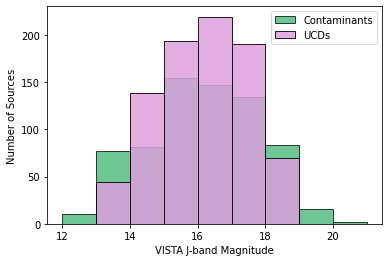

In [131]:
# highlighting UCDs in J-band photometry histogram

bins = np.arange(12, 22, 1)

plt.hist(mc_contams['VISTA_J'], bins = bins, color = 'mediumseagreen', \
         edgecolor = 'k', alpha = 0.75)
plt.hist(mc_sample_shifted['VISTA_J'], bins = bins, color='plum', \
         edgecolor='k', alpha = 0.85)
#plt.title('Distribution of J-band Photometry', fontsize = 15)
plt.xlabel('VISTA J-band Magnitude')
plt.ylabel('Number of Sources')
plt.legend(('Contaminants', 'UCDs'))
plt.savefig('jbandhistmod.png')

In [134]:
# split the contaminants and ucds into their bins

ucd_j1_add = mc_sample_shifted.loc[mc_sample_shifted['VISTA_J'] <= 14]
ucd_j2_add = mc_sample_shifted.loc[(mc_sample_shifted['VISTA_J'] > 14) & (mc_sample_shifted['VISTA_J'] <= 15)]
ucd_j3_add = mc_sample_shifted.loc[(mc_sample_shifted['VISTA_J'] > 15) & (mc_sample_shifted['VISTA_J'] <= 16)]
ucd_j4_add = mc_sample_shifted.loc[(mc_sample_shifted['VISTA_J'] > 16) & (mc_sample_shifted['VISTA_J'] <= 17)]
ucd_j5_add = mc_sample_shifted.loc[(mc_sample_shifted['VISTA_J'] > 17) & (mc_sample_shifted['VISTA_J'] <= 18)]
ucd_j6_add = mc_sample_shifted.loc[(mc_sample_shifted['VISTA_J'] > 18) & (mc_sample_shifted['VISTA_J'] <= 19)]

ucd_binsizes2 = np.array([len(ucd_j1_add), len(ucd_j2_add), len(ucd_j3_add), len(ucd_j4_add), len(ucd_j5_add), len(ucd_j6_add)])

contam_j1_add = mc_contams.loc[(mc_contams['VISTA_J'] > 13) & (mc_contams['VISTA_J'] <= 14)]
contam_j2_add = mc_contams.loc[(mc_contams['VISTA_J'] > 14) & (mc_contams['VISTA_J'] <= 15)]
contam_j3_add = mc_contams.loc[(mc_contams['VISTA_J'] > 15) & (mc_contams['VISTA_J'] <= 16)]
contam_j4_add = mc_contams.loc[(mc_contams['VISTA_J'] > 16) & (mc_contams['VISTA_J'] <= 17)]
contam_j5_add = mc_contams.loc[(mc_contams['VISTA_J'] > 17) & (mc_contams['VISTA_J'] <= 18)]
contam_j6_add = mc_contams.loc[(mc_contams['VISTA_J'] > 18) & (mc_contams['VISTA_J'] <= 19)]

contam_binsizes2 = np.array([len(contam_j1_add), len(contam_j2_add), len(contam_j3_add), len(contam_j4_add), len(contam_j5_add), len(contam_j6_add)])

print(ucd_binsizes2, contam_binsizes2)

[ 44 138 193 219 190  70] [ 77  81 154 147 134  83]


In [138]:
# select a UCD and generate 1000 using noise for new bin 1

photometry_list = []
noise_list = []

for i in range(len(ucd_j1_add)):
    UCD_phot = ucd_j1_add.iloc[i,:8]
    UCD_unc = ucd_j1_add.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j1_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j1_overadd['label'] = 1

# select contaminants and generate noise for new bin 1

photometry_list = []
noise_list = []

for i in range(len(contam_j1_add)):
    contam_phot = contam_j1_add.iloc[i,:8]
    contam_unc = contam_j1_add.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j1_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j1_overadd['label'] = 0

# combine bin 1

j1_oversamp_add = pd.concat([ucd_j1_overadd, contam_j1_overadd], axis = 0)
j1_oversamp_add

In [139]:
# testing RF on seventh bin

X_mc1a = j1_oversamp_add.drop(columns='label')
y_mc1a = j1_oversamp_add['label']

# finding the precision
y_pred_mc1a = RF_model2.predict(X_mc1a)

# do classification report
print(confusion_matrix(y_mc1a, y_pred_mc1a))

# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc1a, y_pred_mc1a).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin1_shifted'] = [tn, fp, fn, tp]
brightness_bias

[[41521 35479]
 [    0 44000]]


,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin1_shifted
0,0,5613,41477,54866,142218,144946,133968,[83000],[18000],41521
1,0,4387,35523,26134,11782,2054,32,0,0,35479
2,0,0,726,13,3425,5452,0,0,0,0
3,[44000],138000,192274,218987,186575,64548,0,0,0,44000


In [140]:
# select a UCD and generate 1000 using noise for shifted bin 2

photometry_list = []
noise_list = []

for i in range(len(ucd_j2_add)):
    UCD_phot = ucd_j2_add.iloc[i,:8]
    UCD_unc = ucd_j2_add.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j2_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j2_overadd['label'] = 1

photometry_list = []
noise_list = []

# select contaminants and generate 1000 using noise for shifted bin 2

for i in range(len(contam_j2_add)):
    contam_phot = contam_j2_add.iloc[i,:8]
    contam_unc = contam_j2_add.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j2_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j2_overadd['label'] = 0

j2_oversamp_add = pd.concat([ucd_j2_overadd, contam_j2_overadd], axis = 0)
j2_oversamp_add

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,18.896552,16.364572,14.996681,14.602504,14.969504,12.019454,11.694328,11.551398,1
1,18.900460,16.363599,15.014876,14.587248,14.960905,12.011001,11.700974,11.545390,1
2,18.902912,16.355298,15.011413,14.605457,14.981221,12.017211,11.720292,11.539266,1
3,18.901927,16.363476,15.010386,14.594552,14.970822,12.013317,11.730001,11.564559,1
4,18.903322,16.366815,15.000820,14.600804,14.989012,12.026496,11.708319,11.539609,1
...,...,...,...,...,...,...,...,...,...
80995,10.288934,30.379451,20.027287,19.987825,-0.833152,4.861398,0.006188,0.023571,0
80996,25.757502,22.715861,20.026459,19.988769,5.962957,10.746683,0.039110,0.042695,0
80997,17.020247,23.211179,20.025847,19.988635,9.222890,-5.607742,0.012836,0.004571,0
80998,20.337469,19.016089,20.029649,19.988891,5.268521,4.845214,-0.006676,0.005264,0


In [141]:
# testing RF on second shifted bin

X_mc2a = j2_oversamp_add.drop(columns='label')
y_mc2a = j2_oversamp_add['label']

# finding the precision
y_pred_mc2a = RF_model2.predict(X_mc2a)

# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc2a, y_pred_mc2a).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin2_shifted'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin1_shifted,bin2_shifted
0,0,5613,41477,54866,142218,144946,133968,[83000],[18000],41521,54958
1,0,4387,35523,26134,11782,2054,32,0,0,35479,26042
2,0,0,726,13,3425,5452,0,0,0,0,0
3,[44000],138000,192274,218987,186575,64548,0,0,0,44000,138000


In [142]:
# select a UCD and generate 1000 using noise for bin 3

photometry_list = []
noise_list = []

for i in range(len(ucd_j3_add)):
    UCD_phot = ucd_j3_add.iloc[i,:8]
    UCD_unc = ucd_j3_add.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j3_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j3_overadd['label'] = 1

photometry_list = []
noise_list = []

for i in range(len(contam_j3_add)):
    contam_phot = contam_j3_add.iloc[i,:8]
    contam_unc = contam_j3_add.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j3_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j3_overadd['label'] = 0

j3_oversamp_add = pd.concat([ucd_j3_overadd, contam_j3_overadd], axis = 0)

In [143]:
# testing RF on second shifted bin

X_mc3a = j3_oversamp_add.drop(columns='label')
y_mc3a = j3_oversamp_add['label']

# finding the precision
y_pred_mc3a = RF_model2.predict(X_mc3a)

# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc3a, y_pred_mc3a).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin3_shifted'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin1_shifted,bin2_shifted,bin3_shifted
0,0,5613,41477,54866,142218,144946,133968,[83000],[18000],41521,54958,142310
1,0,4387,35523,26134,11782,2054,32,0,0,35479,26042,11690
2,0,0,726,13,3425,5452,0,0,0,0,0,2032
3,[44000],138000,192274,218987,186575,64548,0,0,0,44000,138000,190968


In [144]:
photometry_list = []
noise_list = []

for i in range(len(ucd_j4_add)):
    UCD_phot = ucd_j4_add.iloc[i,:8]
    UCD_unc = ucd_j4_add.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j4_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j4_overadd['label'] = 1

photometry_list = []
noise_list = []

for i in range(len(contam_j4_add)):
    contam_phot = contam_j4_add.iloc[i,:8]
    contam_unc = contam_j4_add.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j4_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j4_overadd['label'] = 0

j4_oversamp_add = pd.concat([ucd_j4_overadd, contam_j4_overadd], axis = 0)

In [145]:
# testing RF on fourth shifted bin

X_mc4a = j4_oversamp_add.drop(columns='label')
y_mc4a = j4_oversamp_add['label']

# finding the precision
y_pred_mc4a = RF_model2.predict(X_mc4a)

# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc4a, y_pred_mc4a).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin4_shifted'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin1_shifted,bin2_shifted,bin3_shifted,bin4_shifted
0,0,5613,41477,54866,142218,144946,133968,[83000],[18000],41521,54958,142310,144971
1,0,4387,35523,26134,11782,2054,32,0,0,35479,26042,11690,2029
2,0,0,726,13,3425,5452,0,0,0,0,0,2032,48777
3,[44000],138000,192274,218987,186575,64548,0,0,0,44000,138000,190968,170223


In [146]:
photometry_list = []
noise_list = []

for i in range(len(ucd_j5_add)):
    UCD_phot = ucd_j5_add.iloc[i,:8]
    UCD_unc = ucd_j5_add.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j5_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j5_overadd['label'] = 1

photometry_list = []
noise_list = []

for i in range(len(contam_j5_add)):
    contam_phot = contam_j5_add.iloc[i,:8]
    contam_unc = contam_j5_add.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j5_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j5_overadd['label'] = 0

j5_oversamp_add = pd.concat([ucd_j5_overadd, contam_j5_overadd], axis = 0)

In [147]:
# testing RF on fifth shifted bin

X_mc5a = j5_oversamp_add.drop(columns='label')
y_mc5a = j5_oversamp_add['label']

# finding the precision
y_pred_mc5a = RF_model2.predict(X_mc5a)

# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc5a, y_pred_mc5a).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin5_shifted'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin1_shifted,bin2_shifted,bin3_shifted,bin4_shifted,bin5_shifted
0,0,5613,41477,54866,142218,144946,133968,[83000],[18000],41521,54958,142310,144971,133966
1,0,4387,35523,26134,11782,2054,32,0,0,35479,26042,11690,2029,34
2,0,0,726,13,3425,5452,0,0,0,0,0,2032,48777,136163
3,[44000],138000,192274,218987,186575,64548,0,0,0,44000,138000,190968,170223,53837


In [149]:
photometry_list = []
noise_list = []

for i in range(len(ucd_j6_add)):
    UCD_phot = ucd_j6_add.iloc[i,:8]
    UCD_unc = ucd_j6_add.iloc[i,8:]
    for j in range(1000):
        n_UCD_phot, n_UCD_unc = addNoise(UCD_phot, UCD_unc, scale = 0.5)
        photometry_list.append(n_UCD_phot)
        noise_list.append(n_UCD_unc)

ucd_j6_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
ucd_j6_overadd['label'] = 1

photometry_list = []
noise_list = []

for i in range(len(contam_j6_add)):
    contam_phot = contam_j6_add.iloc[i,:8]
    contam_unc = contam_j6_add.iloc[i,8:]
    for j in range(1000):
        n_contam_phot, n_contam_unc = addNoise(contam_phot, contam_unc, scale = 0.5)
        photometry_list.append(n_contam_phot)
        noise_list.append(n_contam_unc)

contam_j6_overadd = pd.DataFrame(photometry_list, columns = ['DES_r', 'DES_i', 'DES_z','DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2'])
contam_j6_overadd['label'] = 0

j6_oversamp_add = pd.concat([ucd_j6_overadd, contam_j6_overadd], axis = 0)

In [150]:
# testing RF on sixth shifted bin

X_mc6a = j6_oversamp_add.drop(columns='label')
y_mc6a = j6_oversamp_add['label']

# finding the precision
y_pred_mc6a = RF_model2.predict(X_mc6a)

# get the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_mc6a, y_pred_mc6a).ravel()
    
# store those numbers in a dataframe
brightness_bias['bin6_shifted'] = [tn, fp, fn, tp]
brightness_bias

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin1_shifted,bin2_shifted,bin3_shifted,bin4_shifted,bin5_shifted,bin6_shifted
0,0,5613,41477,54866,142218,144946,133968,[83000],[18000],41521,54958,142310,144971,133966,83000
1,0,4387,35523,26134,11782,2054,32,0,0,35479,26042,11690,2029,34,0
2,0,0,726,13,3425,5452,0,0,0,0,0,2032,48777,136163,15081
3,[44000],138000,192274,218987,186575,64548,0,0,0,44000,138000,190968,170223,53837,54919


## RF Model 5

In [152]:
# create sample using only z, y, J, Ks, W1, W2 bands + pmra + pmdec

model5_sample = model1_sample.copy()
model5_sample = model5_sample.drop(columns = ['DES_r', 'DES_i'])
model5_sample

,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,pmra,pmdec,label
0,15.006034,14.597053,12.971069,12.020320,11.715541,11.548368,0.28670,-0.14543,1
1,14.451741,13.978654,12.306149,11.440610,11.066067,10.776617,0.75823,0.08520,1
2,15.217814,14.760754,13.176828,12.248350,11.901234,11.654826,0.71080,-0.12481,1
3,18.261373,17.708156,15.570878,14.081758,13.482135,13.210293,-0.03300,0.01040,1
4,13.598549,13.301750,11.867781,11.129087,10.894397,10.690052,-0.06100,-0.32135,1
...,...,...,...,...,...,...,...,...,...
1579,17.482481,17.494793,16.580885,16.203932,15.929000,15.767000,-0.01860,-0.03915,0
1580,19.107980,18.691925,17.093600,16.273691,14.940000,14.906000,0.07081,-0.00134,0
1581,17.454308,17.263304,15.933051,15.025026,14.940000,14.906000,0.07081,-0.00134,0
1582,19.902794,19.386797,17.169792,15.884735,15.413000,15.143000,0.11342,-0.07621,0


In [153]:
# creating the random forest model

RSEED = 42  

X5, y5 = model5_sample.drop(columns='label'), model5_sample['label']

x_train5, x_test5, y_train5, y_test5 = train_test_split(X5, y5, train_size = 0.75, random_state=RSEED, shuffle=True)

RF_model5 = RandomForestClassifier(n_estimators = 50, class_weight = None)
RF_model5.fit(x_train5, y_train5)

RandomForestClassifier(n_estimators=50)

In [154]:
# do the prediction

y_pred5 = RF_model5.predict(x_test5)

In [155]:
# finding and storing the model performance

store_model_performace(RF_model5, 'model5', x_train5, x_test5, y_train5, y_test5)
model_performances

The raw features produce a model with precision ~0.8798 !
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       179
           1       0.88      0.94      0.91       217

    accuracy                           0.90       396
   macro avg       0.90      0.89      0.90       396
weighted avg       0.90      0.90      0.90       396

[[151  28]
 [ 12 205]]


,model1,model2,model3,model4,model5
0,0.882609,0.886076,0.927928,0.924779,0.879828
1,0.896465,0.914141,0.931818,0.936869,0.898990
2,0.908277,0.925110,0.938497,0.943567,0.911111
3,0.935484,0.967742,0.949309,0.963134,0.944700
4,152.000000,152.000000,163.000000,162.000000,151.000000
5,27.000000,27.000000,16.000000,17.000000,28.000000
6,14.000000,7.000000,11.000000,8.000000,12.000000
7,203.000000,210.000000,206.000000,209.000000,205.000000


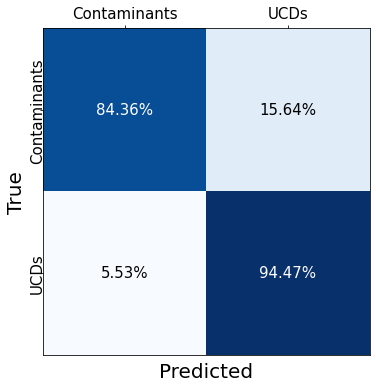

In [156]:
plot_norm_cm(y_test5, y_pred5, cmap = 'Blues')

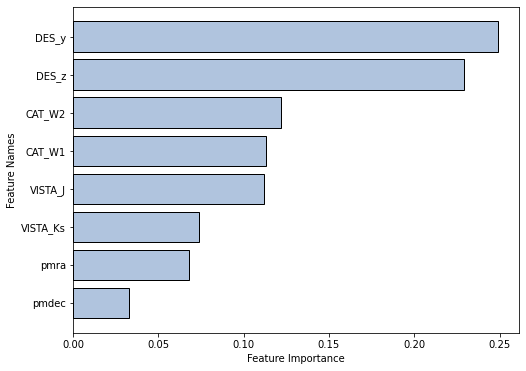

In [158]:
# plot feature importances

plot_feature_importance(RF_model5, model5_sample.drop(columns='label').columns, 8, 'model5features')

## RF Model 6

In [159]:
# create sample using only z, y, J, Ks, W1, W2 bands + pmra + pmdec

model6_sample = model5_sample.copy()
model6_sample = model6_sample.drop(columns = ['pmra', 'pmdec'])
model6_sample

,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,label
0,15.006034,14.597053,12.971069,12.020320,11.715541,11.548368,1
1,14.451741,13.978654,12.306149,11.440610,11.066067,10.776617,1
2,15.217814,14.760754,13.176828,12.248350,11.901234,11.654826,1
3,18.261373,17.708156,15.570878,14.081758,13.482135,13.210293,1
4,13.598549,13.301750,11.867781,11.129087,10.894397,10.690052,1
...,...,...,...,...,...,...,...
1579,17.482481,17.494793,16.580885,16.203932,15.929000,15.767000,0
1580,19.107980,18.691925,17.093600,16.273691,14.940000,14.906000,0
1581,17.454308,17.263304,15.933051,15.025026,14.940000,14.906000,0
1582,19.902794,19.386797,17.169792,15.884735,15.413000,15.143000,0


In [160]:
# creating the random forest model

RSEED = 42  

X6, y6 = model6_sample.drop(columns='label'), model6_sample['label']

x_train6, x_test6, y_train6, y_test6 = train_test_split(X6, y6, train_size = 0.75, random_state=RSEED, shuffle=True)

RF_model6 = RandomForestClassifier(n_estimators = 50, class_weight = None)
RF_model6.fit(x_train6, y_train6)

RandomForestClassifier(n_estimators=50)

In [162]:
# finding prediction

y_pred6 = RF_model6.predict(x_test6)

In [163]:
# finding and storing the model performance

store_model_performace(RF_model6, 'model6', x_train6, x_test6, y_train6, y_test6)
model_performances

The raw features produce a model with precision ~0.8697 !
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       179
           1       0.87      0.95      0.91       217

    accuracy                           0.90       396
   macro avg       0.90      0.89      0.89       396
weighted avg       0.90      0.90      0.90       396

[[148  31]
 [ 10 207]]


,model1,model2,model3,model4,model5,model6
0,0.882609,0.886076,0.927928,0.924779,0.879828,0.869748
1,0.896465,0.914141,0.931818,0.936869,0.898990,0.896465
2,0.908277,0.925110,0.938497,0.943567,0.911111,0.909890
3,0.935484,0.967742,0.949309,0.963134,0.944700,0.953917
4,152.000000,152.000000,163.000000,162.000000,151.000000,148.000000
5,27.000000,27.000000,16.000000,17.000000,28.000000,31.000000
6,14.000000,7.000000,11.000000,8.000000,12.000000,10.000000
7,203.000000,210.000000,206.000000,209.000000,205.000000,207.000000


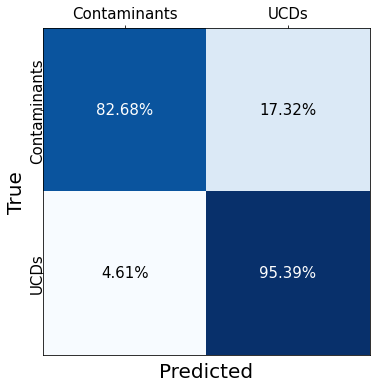

In [164]:
# plot normalized confusion matrix

plot_norm_cm(y_test6, y_pred6, cmap = 'Blues')

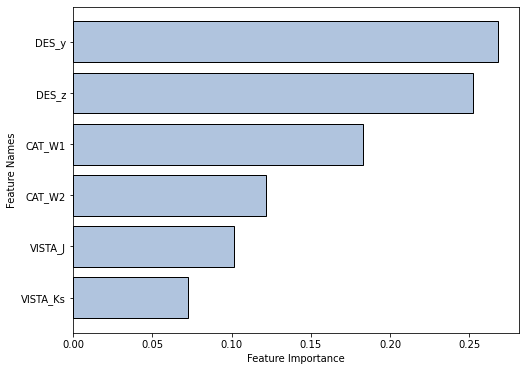

In [165]:
# plot feature importances

plot_feature_importance(RF_model6, model6_sample.drop(columns='label').columns, 6, 'model6features')

## RF Model 7

In [168]:
# create dataframe with all of the color combinations:

color_sample2 = model5_sample.copy()

for i in range(len(model5_sample.columns) - 4):
    for j in range(0, 6): 
        if i != j and i < j:
            color_sample2[color_sample2.columns[i] + '_' + color_sample2.columns[j]] = color_sample2.iloc[:, i] - color_sample2.iloc[:, j]

color_sample2

,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,pmra,pmdec,label,DES_z_DES_y,...,DES_y_VISTA_J,DES_y_VISTA_Ks,DES_y_CAT_W1,DES_y_CAT_W2,VISTA_J_VISTA_Ks,VISTA_J_CAT_W1,VISTA_J_CAT_W2,VISTA_Ks_CAT_W1,VISTA_Ks_CAT_W2,CAT_W1_CAT_W2
0,15.006034,14.597053,12.971069,12.020320,11.715541,11.548368,0.28670,-0.14543,1,0.408982,...,1.625984,2.576733,2.881512,3.048685,0.950749,1.255528,1.422701,0.304778,0.471952,0.167173
1,14.451741,13.978654,12.306149,11.440610,11.066067,10.776617,0.75823,0.08520,1,0.473087,...,1.672505,2.538044,2.912587,3.202037,0.865539,1.240082,1.529532,0.374543,0.663992,0.289449
2,15.217814,14.760754,13.176828,12.248350,11.901234,11.654826,0.71080,-0.12481,1,0.457060,...,1.583925,2.512404,2.859520,3.105928,0.928478,1.275595,1.522003,0.347116,0.593524,0.246408
3,18.261373,17.708156,15.570878,14.081758,13.482135,13.210293,-0.03300,0.01040,1,0.553217,...,2.137278,3.626398,4.226021,4.497862,1.489120,2.088743,2.360584,0.599623,0.871465,0.271842
4,13.598549,13.301750,11.867781,11.129087,10.894397,10.690052,-0.06100,-0.32135,1,0.296799,...,1.433970,2.172663,2.407353,2.611698,0.738693,0.973384,1.177729,0.234690,0.439036,0.204345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,17.482481,17.494793,16.580885,16.203932,15.929000,15.767000,-0.01860,-0.03915,0,-0.012312,...,0.913908,1.290861,1.565793,1.727793,0.376953,0.651885,0.813885,0.274932,0.436932,0.162000
1580,19.107980,18.691925,17.093600,16.273691,14.940000,14.906000,0.07081,-0.00134,0,0.416055,...,1.598325,2.418234,3.751925,3.785925,0.819909,2.153600,2.187600,1.333691,1.367691,0.034000
1581,17.454308,17.263304,15.933051,15.025026,14.940000,14.906000,0.07081,-0.00134,0,0.191004,...,1.330253,2.238278,2.323304,2.357304,0.908025,0.993051,1.027051,0.085026,0.119026,0.034000
1582,19.902794,19.386797,17.169792,15.884735,15.413000,15.143000,0.11342,-0.07621,0,0.515997,...,2.217005,3.502062,3.973797,4.243797,1.285057,1.756792,2.026792,0.471735,0.741735,0.270000


In [171]:
# creating a dataframe with colors as the only feature, retaining the labels

color_sample_model7 = color_sample2.copy()
color_sample_model7 = color_sample_model7.iloc[:, -16:]
color_sample_model7

,label,DES_z_DES_y,DES_z_VISTA_J,DES_z_VISTA_Ks,DES_z_CAT_W1,DES_z_CAT_W2,DES_y_VISTA_J,DES_y_VISTA_Ks,DES_y_CAT_W1,DES_y_CAT_W2,VISTA_J_VISTA_Ks,VISTA_J_CAT_W1,VISTA_J_CAT_W2,VISTA_Ks_CAT_W1,VISTA_Ks_CAT_W2,CAT_W1_CAT_W2
0,1,0.408982,2.034966,2.985715,3.290493,3.457667,1.625984,2.576733,2.881512,3.048685,0.950749,1.255528,1.422701,0.304778,0.471952,0.167173
1,1,0.473087,2.145591,3.011131,3.385674,3.675123,1.672505,2.538044,2.912587,3.202037,0.865539,1.240082,1.529532,0.374543,0.663992,0.289449
2,1,0.457060,2.040986,2.969464,3.316580,3.562988,1.583925,2.512404,2.859520,3.105928,0.928478,1.275595,1.522003,0.347116,0.593524,0.246408
3,1,0.553217,2.690496,4.179615,4.779238,5.051080,2.137278,3.626398,4.226021,4.497862,1.489120,2.088743,2.360584,0.599623,0.871465,0.271842
4,1,0.296799,1.730768,2.469461,2.704152,2.908497,1.433970,2.172663,2.407353,2.611698,0.738693,0.973384,1.177729,0.234690,0.439036,0.204345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,0,-0.012312,0.901596,1.278549,1.553481,1.715481,0.913908,1.290861,1.565793,1.727793,0.376953,0.651885,0.813885,0.274932,0.436932,0.162000
1580,0,0.416055,2.014380,2.834289,4.167980,4.201980,1.598325,2.418234,3.751925,3.785925,0.819909,2.153600,2.187600,1.333691,1.367691,0.034000
1581,0,0.191004,1.521257,2.429282,2.514308,2.548308,1.330253,2.238278,2.323304,2.357304,0.908025,0.993051,1.027051,0.085026,0.119026,0.034000
1582,0,0.515997,2.733002,4.018059,4.489794,4.759794,2.217005,3.502062,3.973797,4.243797,1.285057,1.756792,2.026792,0.471735,0.741735,0.270000


In [172]:
# creating the random forest model

RSEED = 42  

X7, y7 = color_sample_model7.drop(columns='label'), color_sample_model7['label']

x_train7, x_test7, y_train7, y_test7 = train_test_split(X7, y7, train_size = 0.75, random_state=RSEED, shuffle=True)

RF_model7 = RandomForestClassifier(n_estimators = 50, class_weight = None)
RF_model7.fit(x_train7, y_train7)

RandomForestClassifier(n_estimators=50)

In [173]:
# finding prediction

y_pred7 = RF_model7.predict(x_test7)

In [174]:
# finding and storing the model performance

store_model_performace(RF_model7, 'model7', x_train7, x_test7, y_train7, y_test7)
model_performances

The raw features produce a model with precision ~0.8714 !
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       179
           1       0.87      0.97      0.92       217

    accuracy                           0.90       396
   macro avg       0.91      0.90      0.90       396
weighted avg       0.91      0.90      0.90       396

[[148  31]
 [  7 210]]


,model1,model2,model3,model4,model5,model6,model7
0,0.882609,0.886076,0.927928,0.924779,0.879828,0.869748,0.871369
1,0.896465,0.914141,0.931818,0.936869,0.898990,0.896465,0.904040
2,0.908277,0.925110,0.938497,0.943567,0.911111,0.909890,0.917031
3,0.935484,0.967742,0.949309,0.963134,0.944700,0.953917,0.967742
4,152.000000,152.000000,163.000000,162.000000,151.000000,148.000000,148.000000
5,27.000000,27.000000,16.000000,17.000000,28.000000,31.000000,31.000000
6,14.000000,7.000000,11.000000,8.000000,12.000000,10.000000,7.000000
7,203.000000,210.000000,206.000000,209.000000,205.000000,207.000000,210.000000


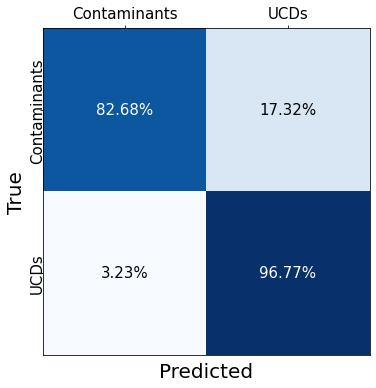

In [175]:
# plot normalized confusion matrix

plot_norm_cm(y_test7, y_pred7, cmap = 'Blues')

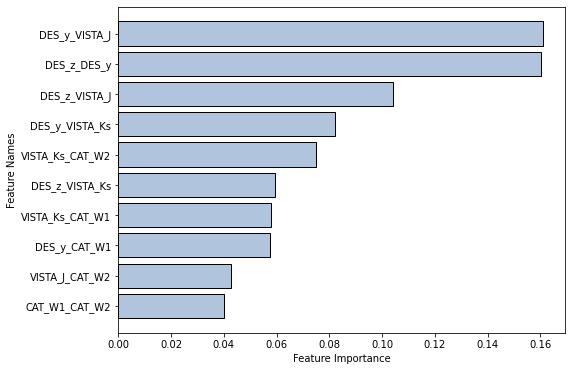

In [178]:
# plot feature importances

plot_feature_importance(RF_model7, color_sample_model7.drop(columns='label').columns, 10, 'model7features')

## RF Model 8

In [179]:
# create sample with the 15 colors + pmra, pmdec

color_sample_model8 = color_sample2.copy()
color_sample_model8 = color_sample_model8.iloc[:, -18:]
color_sample_model8

,pmra,pmdec,label,DES_z_DES_y,DES_z_VISTA_J,DES_z_VISTA_Ks,DES_z_CAT_W1,DES_z_CAT_W2,DES_y_VISTA_J,DES_y_VISTA_Ks,DES_y_CAT_W1,DES_y_CAT_W2,VISTA_J_VISTA_Ks,VISTA_J_CAT_W1,VISTA_J_CAT_W2,VISTA_Ks_CAT_W1,VISTA_Ks_CAT_W2,CAT_W1_CAT_W2
0,0.28670,-0.14543,1,0.408982,2.034966,2.985715,3.290493,3.457667,1.625984,2.576733,2.881512,3.048685,0.950749,1.255528,1.422701,0.304778,0.471952,0.167173
1,0.75823,0.08520,1,0.473087,2.145591,3.011131,3.385674,3.675123,1.672505,2.538044,2.912587,3.202037,0.865539,1.240082,1.529532,0.374543,0.663992,0.289449
2,0.71080,-0.12481,1,0.457060,2.040986,2.969464,3.316580,3.562988,1.583925,2.512404,2.859520,3.105928,0.928478,1.275595,1.522003,0.347116,0.593524,0.246408
3,-0.03300,0.01040,1,0.553217,2.690496,4.179615,4.779238,5.051080,2.137278,3.626398,4.226021,4.497862,1.489120,2.088743,2.360584,0.599623,0.871465,0.271842
4,-0.06100,-0.32135,1,0.296799,1.730768,2.469461,2.704152,2.908497,1.433970,2.172663,2.407353,2.611698,0.738693,0.973384,1.177729,0.234690,0.439036,0.204345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,-0.01860,-0.03915,0,-0.012312,0.901596,1.278549,1.553481,1.715481,0.913908,1.290861,1.565793,1.727793,0.376953,0.651885,0.813885,0.274932,0.436932,0.162000
1580,0.07081,-0.00134,0,0.416055,2.014380,2.834289,4.167980,4.201980,1.598325,2.418234,3.751925,3.785925,0.819909,2.153600,2.187600,1.333691,1.367691,0.034000
1581,0.07081,-0.00134,0,0.191004,1.521257,2.429282,2.514308,2.548308,1.330253,2.238278,2.323304,2.357304,0.908025,0.993051,1.027051,0.085026,0.119026,0.034000
1582,0.11342,-0.07621,0,0.515997,2.733002,4.018059,4.489794,4.759794,2.217005,3.502062,3.973797,4.243797,1.285057,1.756792,2.026792,0.471735,0.741735,0.270000


In [181]:
# creating the random forest model

RSEED = 42  

X8, y8 = color_sample_model8.drop(columns='label'), color_sample_model8['label']

x_train8, x_test8, y_train8, y_test8 = train_test_split(X8, y8, train_size = 0.75, random_state=RSEED, shuffle=True)

RF_model8 = RandomForestClassifier(n_estimators = 50, class_weight = None)
RF_model8.fit(x_train8, y_train8)

RandomForestClassifier(n_estimators=50)

In [182]:
# finding prediction

y_pred8 = RF_model8.predict(x_test8)

In [183]:
# finding and storing the model performance

store_model_performace(RF_model8, 'model8', x_train8, x_test8, y_train8, y_test8)
model_performances

The raw features produce a model with precision ~0.8692 !
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       179
           1       0.87      0.95      0.91       217

    accuracy                           0.89       396
   macro avg       0.90      0.89      0.89       396
weighted avg       0.90      0.89      0.89       396

[[148  31]
 [ 11 206]]


,model1,model2,model3,model4,model5,model6,model7,model8
0,0.882609,0.886076,0.927928,0.924779,0.879828,0.869748,0.871369,0.869198
1,0.896465,0.914141,0.931818,0.936869,0.898990,0.896465,0.904040,0.893939
2,0.908277,0.925110,0.938497,0.943567,0.911111,0.909890,0.917031,0.907489
3,0.935484,0.967742,0.949309,0.963134,0.944700,0.953917,0.967742,0.949309
4,152.000000,152.000000,163.000000,162.000000,151.000000,148.000000,148.000000,148.000000
5,27.000000,27.000000,16.000000,17.000000,28.000000,31.000000,31.000000,31.000000
6,14.000000,7.000000,11.000000,8.000000,12.000000,10.000000,7.000000,11.000000
7,203.000000,210.000000,206.000000,209.000000,205.000000,207.000000,210.000000,206.000000


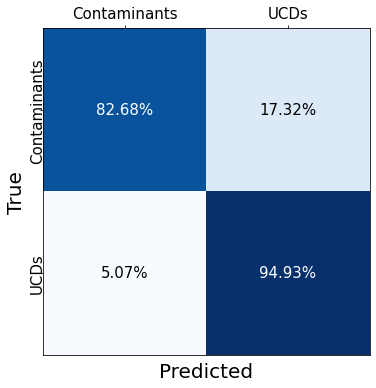

In [184]:
# plot normalized confusion matrix

plot_norm_cm(y_test8, y_pred8, cmap = 'Blues')

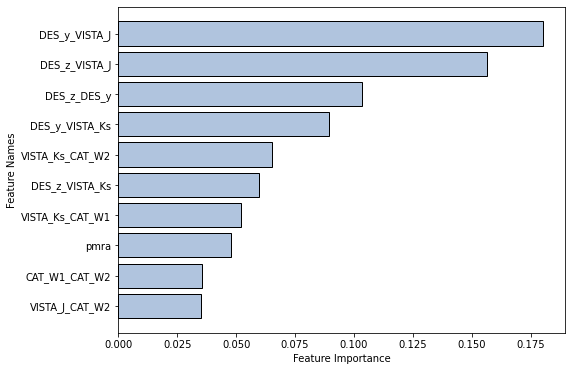

In [185]:
# plot feature importances

plot_feature_importance(RF_model8, color_sample_model8.drop(columns='label').columns, 10, 'model8features')

In [212]:
# opening tiles for rf processing

tile1 = pd.read_csv('tile1.csv')
tile1.columns

Index(['t1_ra_des_x', 't1_dec_des_x', 't1_wavg_mag_psf_r_x',
       't1_wavg_mag_psf_i_x', 't1_wavg_mag_psf_z_x', 't1_wavg_mag_psf_y_x',
       't1_wavg_magerr_psf_r_x', 't1_wavg_magerr_psf_i_x',
       't1_wavg_magerr_psf_z_x', 't1_wavg_magerr_psf_y_x', 't1_tilename_x',
       't1_index', 'dec2000', 'japermag3', 'japermag3err', 'ksapermag3',
       'ksapermag3err', 'pgalaxy', 'pstar', 'ra2000', 'sourceid',
       'dist_arcsec_x', 't1_ra_des_y', 't1_dec_des_y', 't1_wavg_mag_psf_r_y',
       't1_wavg_mag_psf_i_y', 't1_wavg_mag_psf_z_y', 't1_wavg_mag_psf_y_y',
       't1_wavg_magerr_psf_r_y', 't1_wavg_magerr_psf_i_y',
       't1_wavg_magerr_psf_z_y', 't1_wavg_magerr_psf_y_y', 't1_tilename_y',
       'dec', 'pmdec', 'pmra', 'ra', 'source_id', 'w1mpro', 'w1sigmpro',
       'w2mpro', 'w2sigmpro', 'dist_arcsec_y'],
      dtype='object')

In [213]:
tile1 = tile1.drop(columns = ['dec2000', 'ra2000', 't1_wavg_magerr_psf_r_x', 't1_wavg_magerr_psf_i_x', \
                              't1_wavg_magerr_psf_z_x', 't1_wavg_magerr_psf_y_x', 't1_tilename_x', 't1_index', \
                              'sourceid', 'dist_arcsec_x', 't1_ra_des_y', 't1_dec_des_y', 't1_wavg_mag_psf_r_y', \
                              't1_wavg_mag_psf_i_y', 't1_wavg_mag_psf_z_y', 't1_wavg_mag_psf_y_y', \
                              't1_wavg_magerr_psf_r_y', 't1_wavg_magerr_psf_i_y', 't1_wavg_magerr_psf_z_y', \
                              't1_wavg_magerr_psf_y_y', 't1_tilename_y', 'dec', 'ra', 'source_id', 'w1sigmpro', \
                              'w2sigmpro', 'dist_arcsec_y', 'japermag3err', 'ksapermag3err'])

In [214]:
tile1.columns

Index(['t1_ra_des_x', 't1_dec_des_x', 't1_wavg_mag_psf_r_x',
       't1_wavg_mag_psf_i_x', 't1_wavg_mag_psf_z_x', 't1_wavg_mag_psf_y_x',
       'japermag3', 'ksapermag3', 'pgalaxy', 'pstar', 'pmdec', 'pmra',
       'w1mpro', 'w2mpro'],
      dtype='object')

In [215]:
tile1 = tile1.rename(columns = {'t1_ra_des_x' : 'ra_des' , 't1_dec_des_x' : 'dec_des', 
                                't1_wavg_mag_psf_r_x' : 'DES_r', 't1_wavg_mag_psf_i_x' : 'DES_i', 
                                't1_wavg_mag_psf_z_x' : 'DES_z', 't1_wavg_mag_psf_y_x' : 'DES_y', 
                                'japermag3' : 'VISTA_J', 'ksapermag3' : 'VISTA_Ks', 
                                'w1mpro' : 'CAT_W1', 'w2mpro' : 'CAT_W2'})

In [216]:
tile1.columns

Index(['ra_des', 'dec_des', 'DES_r', 'DES_i', 'DES_z', 'DES_y', 'VISTA_J',
       'VISTA_Ks', 'pgalaxy', 'pstar', 'pmdec', 'pmra', 'CAT_W1', 'CAT_W2'],
      dtype='object')

In [218]:
tile1 = tile1[['ra_des', 'dec_des', 'pgalaxy', 'pstar', 'DES_r', 'DES_i', 'DES_z', \
               'DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2', 'pmdec', 'pmra', ]]
tile1

,ra_des,dec_des,pgalaxy,pstar,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,pmdec,pmra
0,56.226306,-44.233302,0.003067,0.993865,18.223051,17.427120,17.065117,16.970337,15.776182,15.035671,14.973,14.892,0.01724,0.02812
1,85.500162,-30.308242,0.003067,0.993865,20.335947,19.308860,18.862200,18.761667,17.533144,16.825476,16.365,16.226,-0.04330,0.03760
2,357.504155,-40.141246,0.003067,0.993865,19.658913,18.851297,18.489779,18.417759,17.262236,16.485014,16.382,16.419,0.02385,-0.00882
3,85.632885,-30.172703,0.003067,0.993865,19.528530,19.358310,19.278145,19.272032,18.327297,17.759436,17.158,17.342,0.06150,0.02613
4,75.993013,-24.849460,0.486486,0.486486,19.816967,19.524220,19.375053,19.326475,18.209187,17.630600,17.472,17.206,0.12000,0.04602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81404,33.043902,-1.801991,0.000171,0.999657,21.506240,21.451944,21.446753,21.458673,17.629800,16.841208,18.058,17.757,0.11995,-0.17936
81405,353.122385,-57.721306,0.000171,0.999657,21.964770,21.641855,21.438955,21.230310,13.014577,12.707729,18.005,17.139,0.14529,0.13919
81406,35.721549,-53.012463,0.993865,0.003067,22.670938,22.055292,21.805725,21.384796,19.954750,18.133076,18.824,18.450,-0.22569,-0.08138
81407,322.929929,-48.155705,0.999657,0.000171,23.509275,22.774015,22.269691,21.994427,18.918665,17.462168,18.223,17.763,0.02590,-0.42651


In [220]:
test1 = tile1.iloc[:, -10:]
test1

,DES_r,DES_i,DES_z,DES_y,VISTA_J,VISTA_Ks,CAT_W1,CAT_W2,pmdec,pmra
0,18.223051,17.427120,17.065117,16.970337,15.776182,15.035671,14.973,14.892,0.01724,0.02812
1,20.335947,19.308860,18.862200,18.761667,17.533144,16.825476,16.365,16.226,-0.04330,0.03760
2,19.658913,18.851297,18.489779,18.417759,17.262236,16.485014,16.382,16.419,0.02385,-0.00882
3,19.528530,19.358310,19.278145,19.272032,18.327297,17.759436,17.158,17.342,0.06150,0.02613
4,19.816967,19.524220,19.375053,19.326475,18.209187,17.630600,17.472,17.206,0.12000,0.04602
...,...,...,...,...,...,...,...,...,...,...
81404,21.506240,21.451944,21.446753,21.458673,17.629800,16.841208,18.058,17.757,0.11995,-0.17936
81405,21.964770,21.641855,21.438955,21.230310,13.014577,12.707729,18.005,17.139,0.14529,0.13919
81406,22.670938,22.055292,21.805725,21.384796,19.954750,18.133076,18.824,18.450,-0.22569,-0.08138
81407,23.509275,22.774015,22.269691,21.994427,18.918665,17.462168,18.223,17.763,0.02590,-0.42651


In [266]:

def tile_processing_model7(tilename):
    '''
    tilename = string containing name of csv file containing des/vista/catwise cross-matched data
    '''
    # open tile
    
    tile = pd.read_csv(tilename)
    
    # do column processing
    
    tile = tile.drop(columns = ['dec2000', 'ra2000', 't1_wavg_magerr_psf_r_x', 't1_wavg_magerr_psf_i_x', \
                                't1_wavg_magerr_psf_z_x', 't1_wavg_magerr_psf_y_x', 't1_tilename_x', 't1_index', \
                                'sourceid', 'dist_arcsec_x', 't1_ra_des_y', 't1_dec_des_y', 't1_wavg_mag_psf_r_y', \
                                't1_wavg_mag_psf_i_y', 't1_wavg_mag_psf_z_y', 't1_wavg_mag_psf_y_y', \
                                't1_wavg_magerr_psf_r_y', 't1_wavg_magerr_psf_i_y', 't1_wavg_magerr_psf_z_y', \
                                't1_wavg_magerr_psf_y_y', 't1_tilename_y', 'dec', 'ra', 'source_id', 'w1sigmpro', \
                                'w2sigmpro', 'dist_arcsec_y', 'japermag3err', 'ksapermag3err'])
    
    tile = tile.rename(columns = {'t1_ra_des_x' : 'ra_des' , 't1_dec_des_x' : 'dec_des', 
                                  't1_wavg_mag_psf_r_x' : 'DES_r', 't1_wavg_mag_psf_i_x' : 'DES_i', 
                                  't1_wavg_mag_psf_z_x' : 'DES_z', 't1_wavg_mag_psf_y_x' : 'DES_y', 
                                  'japermag3' : 'VISTA_J', 'ksapermag3' : 'VISTA_Ks', 
                                  'w1mpro' : 'CAT_W1', 'w2mpro' : 'CAT_W2'})

    tile = tile[['DES_z', 'DES_y', 'VISTA_J', 'VISTA_Ks', 'CAT_W1', 'CAT_W2',
                 'ra_des', 'dec_des', 'pgalaxy', 'pstar', ]]
    
    batch = tile.copy()
    
    for i in range(len(batch.columns) - 4):
        for j in range(0, 6): 
            if i != j and i < j:
                batch[batch.columns[i] + '_' + batch.columns[j]] = batch.iloc[:, i] - batch.iloc[:, j]
                
    batch = batch.dropna()

    return batch

,t1_ra_des_x,t1_dec_des_x,t1_wavg_mag_psf_r_x,t1_wavg_mag_psf_i_x,t1_wavg_mag_psf_z_x,t1_wavg_mag_psf_y_x,t1_wavg_magerr_psf_r_x,t1_wavg_magerr_psf_i_x,t1_wavg_magerr_psf_z_x,t1_wavg_magerr_psf_y_x,...,dec,pmdec,pmra,ra,source_id,w1mpro,w1sigmpro,w2mpro,w2sigmpro,dist_arcsec_y
0,91.390896,-38.088054,21.512280,20.168736,19.578970,19.418917,0.008129,0.004172,0.003980,0.011422,...,-38.088002,0.03590,-0.01863,91.390873,0909m379_b0-044805,17.365,0.054,17.469,0.180,0.197941
1,74.617601,-22.461176,21.596590,20.519892,20.056671,19.940350,0.009672,0.005904,0.006952,0.020892,...,-22.461400,-0.06300,0.00129,74.617537,0749m228_b0-030622,17.170,0.052,18.047,0.338,0.834121
2,80.472031,-47.355080,17.967650,17.186594,16.835861,16.743542,0.000893,0.000635,0.000730,0.001838,...,-47.355052,0.01410,0.00723,80.472018,0807m470_b0-003155,14.679,0.013,14.609,0.015,0.104003
3,59.349802,-34.200237,23.110390,21.206509,20.410843,20.198885,0.033668,0.010307,0.008795,0.023938,...,-34.200270,0.05018,0.00262,59.349831,0584m349_b0-044557,17.807,0.085,17.635,0.240,0.146287
4,90.806865,-37.892330,20.003904,19.077910,18.675858,18.570549,0.002822,0.002125,0.002299,0.007298,...,-37.892355,-0.03960,0.02088,90.806843,0909m379_b0-020512,16.536,0.030,16.572,0.080,0.110357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87785,65.577730,-31.139274,22.251146,22.105444,22.011072,21.432442,0.018921,0.023928,0.045478,0.219273,...,-31.142318,-0.12700,0.04106,65.575503,0652m319_b0-038321,17.711,0.088,16.806,0.113,12.927642
87786,25.790279,-2.402925,23.011310,22.366596,22.061266,21.372444,0.038782,0.032754,0.048156,0.198655,...,-2.405978,-0.12777,0.30148,25.792949,0257m031_b0-053588,18.039,0.121,17.725,0.329,14.594687
87787,59.186496,-25.946321,-99.000000,23.395525,22.501520,22.134212,-99.000000,0.107568,0.084017,0.145721,...,-25.946715,0.08400,-0.10426,59.186522,0600m258_b0-025449,17.341,0.064,17.275,0.186,1.420953
87788,25.741406,-2.357816,21.329147,21.222050,21.221075,21.300972,0.009697,0.012538,0.026131,0.115627,...,-2.358539,-0.14106,-0.04662,25.743427,0257m031_b0-052518,18.362,0.181,17.243,0.196,7.722926


In [275]:
def detect_UCDs_in_batch(batch_df, batch_features):
    # Use Random Forest classifier to detect UCDs
    assert(len(batch_features.columns) == 15)
    candidate_bool_arr = RF_model7.predict(batch_features)
    batch_df['prediction'] = candidate_bool_arr
    candidate_df = batch_df[batch_df['prediction'] == 1]
    return candidate_df


In [322]:
def detect_UCDs_in_dataset():
    # iterate through the set of data (one batch at a time) and detect
    # UCDs in each batch
    debug_cols = None
    big_candidates_df = pd.DataFrame()
    
    for i in range(26,40):
        try:
            #tile_df = read_merged_tile('tile%d.csv' % i)
            batch_df = tile_processing_model7('tile%d.csv' % i)
            batch_features = batch_df.copy()
            batch_features = batch_features.iloc[:,-15:]
            assert((debug_cols == None) or (batch_features.columns == debug_cols))
            candidate_df = detect_UCDs_in_batch(batch_df, batch_features)
            # TBD: concatenate candidate_df
            print('------------')
            print('--- %d len candidate_df %d' % (i, len(candidate_df)))
            big_candidates_df = pd.concat([big_candidates_df, candidate_df], axis = 0)
        except ValueError:
            print (i)
            print (batch_features)
            print (batch_features.columns)
            print (batch_features.info())
            
    return big_candidates_df

In [326]:
debug_tile = tile_processing_model7('tile29.csv')

In [328]:
debug_tile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DES_z             0 non-null      object
 1   DES_y             0 non-null      object
 2   VISTA_J           0 non-null      object
 3   VISTA_Ks          0 non-null      object
 4   CAT_W1            0 non-null      object
 5   CAT_W2            0 non-null      object
 6   ra_des            0 non-null      object
 7   dec_des           0 non-null      object
 8   pgalaxy           0 non-null      object
 9   pstar             0 non-null      object
 10  DES_z_DES_y       0 non-null      object
 11  DES_z_VISTA_J     0 non-null      object
 12  DES_z_VISTA_Ks    0 non-null      object
 13  DES_z_CAT_W1      0 non-null      object
 14  DES_z_CAT_W2      0 non-null      object
 15  DES_y_VISTA_J     0 non-null      object
 16  DES_y_VISTA_Ks    0 non-null      object
 17  DES_y_CAT_W1      0 non-null     

In [325]:
big_UCD_df = detect_UCDs_in_dataset()

------------
--- 26 len candidate_df 1995
------------
--- 27 len candidate_df 1574
------------
--- 28 len candidate_df 1774
29
Empty DataFrame
Columns: [DES_z_DES_y, DES_z_VISTA_J, DES_z_VISTA_Ks, DES_z_CAT_W1, DES_z_CAT_W2, DES_y_VISTA_J, DES_y_VISTA_Ks, DES_y_CAT_W1, DES_y_CAT_W2, VISTA_J_VISTA_Ks, VISTA_J_CAT_W1, VISTA_J_CAT_W2, VISTA_Ks_CAT_W1, VISTA_Ks_CAT_W2, CAT_W1_CAT_W2]
Index: []
Index(['DES_z_DES_y', 'DES_z_VISTA_J', 'DES_z_VISTA_Ks', 'DES_z_CAT_W1',
       'DES_z_CAT_W2', 'DES_y_VISTA_J', 'DES_y_VISTA_Ks', 'DES_y_CAT_W1',
       'DES_y_CAT_W2', 'VISTA_J_VISTA_Ks', 'VISTA_J_CAT_W1', 'VISTA_J_CAT_W2',
       'VISTA_Ks_CAT_W1', 'VISTA_Ks_CAT_W2', 'CAT_W1_CAT_W2'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DES_z_DES_y       0 non-null      object
 1   DES_z_VISTA_J     0 non-null      object
 2   DES_z_VISTA_Ks   

In [ ]:
big_UCD_df.info()